# 계류 법안 분석 

작성자: 박하람

In [1]:
import sys
sys.path.append("/usr/local/lib/python3.8/site-packages")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [3]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [4]:
bill20_df = pd.read_csv('bill_20th_data_final.csv', parse_dates=['제안일자','의결일자'])
bill20_df = bill20_df[['의안번호','의안명','제안자구분','제안일자','의결일자','의결결과','제안회기','제안이유','소관위원회','제안정당','법률반영여부']]

In [5]:
bill20_df.shape

(23684, 11)

In [6]:
bill21_df = pd.read_csv('bill-21st-data-final.csv', index_col=0, 
                        parse_dates=['제안일자','의결일자'])
bill21_df = bill21_df[['의안번호','의안명','제안자구분','제안일자','의결일자','의결결과',
                       '제안회기','제안이유','소관위원회','제안정당']]

In [7]:
accept_list = ['대안반영폐기', '원안가결', '수정가결', '수정안반영폐기', '가결']

## 의결결과가 '대안반영폐기', '원안가결', '수정가결', '수정안반영폐기', '가결' 이면 법률반영
## 그외 법률미반영
bill21_df.loc[bill21_df['의결결과'].isin(accept_list), '법률반영여부'] = '반영'
bill21_df.loc[~bill21_df['의결결과'].isin(accept_list), '법률반영여부'] = '미반영'

In [8]:
bill21_df.shape

(3687, 11)

In [9]:
bill_df = pd.concat([bill20_df, bill21_df]).reset_index().drop('index', 1)

In [10]:
bill_df.shape

(27371, 11)

## 데이터 전처리 

- 법률안만 선정

> 의안의 결과를 예측하기 위해서는 먼저 문제의 특성을 잘 이해하는 것이 중요하다. 먼저 의안에는 기존 법률을 수정, 폐지하거나 새로운 법률을 제안하는 법률안만 있는 것이 아니라 결의안, 동의안, 출석요구안, 예산안, 정부 관리직의 임명선출안 등도 포함된다. 그 중에서 일반 시민 및 각종 이익 단체에 영향을 가장 크게 주는 것은 법을 수정하는 법률안이므로, 이 연구에서는 법률안에 중점을 둔다.(선행연구)

#### 법률안 추리기

In [11]:
from ast import literal_eval

def split_name(text): 
    name = text.split('(')[0]
    return name

def preprocessing(text):
    # 특수문자 제거
    text = re.sub('[?.,;:|\)(*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    return text

def str_to_list(x): 
    party = literal_eval(x)
    return party

def get_party(df): 
    partylist = []
    for i in range(len(df)): 
        for j in range(len(df['제안정당'][i])): 
            party = df['제안정당'][i][j]
            if party not in partylist:
                partylist.append(df['제안정당'][i][j]) 
    return partylist

In [12]:
bill_df['의안명'] = bill_df['의안명'].apply(split_name)

In [13]:
bill_df.loc[bill_df['의안명'].str.endswith('법률안') == True, '법률안'] = 1
bill_df.loc[bill_df['의안명'].str.endswith('법률안') == False, '법률안'] = 0

In [14]:
# 법률안을 제외하면 1231개임 
bill_df['법률안'].value_counts()

1.0    26140
0.0     1231
Name: 법률안, dtype: int64

In [15]:
bill_df = bill_df[bill_df['법률안'] == 1]
bill_df = bill_df.reset_index()
bill_df = bill_df.drop('index',1)

In [16]:
len(bill_df)

26140

In [17]:
# object를 list로 변화! 
%time bill_df['제안정당'] = bill_df['제안정당'].apply(str_to_list)

CPU times: user 270 ms, sys: 13.3 ms, total: 283 ms
Wall time: 292 ms


#### 정당별 칼럼 만들기

In [18]:
get_party(bill_df)

['더불어민주당',
 '자유한국당',
 '미래통합당',
 '미래한국당',
 '민생당',
 '더불어시민당',
 '국민의당',
 '무소속',
 '민중당',
 '정의당',
 '우리공화당',
 '',
 '대안신당',
 '바른미래당',
 '새로운보수당',
 '미래를향한전진4.0',
 '민주평화당',
 '대한애국당',
 '새누리당',
 '바른정당',
 '새민중정당',
 '개혁보수신당',
 '열린민주당',
 '기본소득당',
 '시대전환']

In [19]:
party_df = bill_df['제안정당'].apply(lambda x: pd.Series(x))
party_df.columns = ['제안정당_1','제안정당_2','제안정당_3','제안정당_4','제안정당_5','제안정당_6','제안정당_7','제안정당_8']
                    
# 원핫인코딩을 통해 정당이 칼럼명인 데이터 프레임을 만들고 모두 합칩니다.
df1 = pd.get_dummies(party_df['제안정당_1'])
df2 = pd.get_dummies(party_df['제안정당_2'])
df3 = pd.get_dummies(party_df['제안정당_3'])
df4 = pd.get_dummies(party_df['제안정당_4'])
df5 = pd.get_dummies(party_df['제안정당_5'])
df6 = pd.get_dummies(party_df['제안정당_6'])
df7 = pd.get_dummies(party_df['제안정당_7'])
df8 = pd.get_dummies(party_df['제안정당_8'])

df = df1.add(df2, fill_value=0).add(df3, fill_value=0).add(df4, fill_value=0).add(df5, fill_value=0).add(df6, fill_value=0).add(df7, fill_value=0).add(df8, fill_value=0)

# 원본데이터와 합칩니다.
bill_df = pd.concat([bill_df, df], axis=1)

In [20]:
bill_df.columns

Index(['의안번호', '의안명', '제안자구분', '제안일자', '의결일자', '의결결과', '제안회기', '제안이유', '소관위원회',
       '제안정당', '법률반영여부', '법률안', '', '개혁보수신당', '국민의당', '기본소득당', '대안신당', '대한애국당',
       '더불어민주당', '더불어시민당', '무소속', '미래를향한전진4.0', '미래통합당', '미래한국당', '민생당',
       '민주평화당', '민중당', '바른미래당', '바른정당', '새누리당', '새로운보수당', '새민중정당', '시대전환',
       '열린민주당', '우리공화당', '자유한국당', '정의당'],
      dtype='object')

## EDA 

### 법률 반영/미반영 기준으로 의안처리시 소요시간 분석

- 법률반영: 원안가결, 원안수정, 대안반영, 수정안반영
- 법률미반영: 부결, 폐기, 철회, 반려, 기타 

In [21]:
bill_df['의결결과'] = bill_df['의결결과'].fillna('')

In [22]:
bill_df['의결결과'].unique()

array(['임기만료폐기', '원안가결', '수정가결', '대안반영폐기', '철회', '폐기', '부결', '수정안반영폐기',
       ''], dtype=object)

In [23]:
bill_df.loc[bill_df['의결결과'] == '', '의결결과'] = '계류'

- accept_list = ['대안반영폐기', '원안가결', '수정가결', '수정안반영폐기', '가결']
- reject_list = ['임기만료폐기', '부결', '철회', '반려', '심사대상제외', '폐기']

In [24]:
bill_tmp = bill_df['의결결과'].value_counts()
bill_tmp

임기만료폐기     14269
대안반영폐기      5026
계류          3617
원안가결        1976
수정가결         862
철회           226
폐기           121
수정안반영폐기       41
부결             2
Name: 의결결과, dtype: int64

In [25]:
bill_df['법률반영여부'].value_counts()

미반영    18235
반영      7905
Name: 법률반영여부, dtype: int64

In [26]:
bill_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26140 entries, 0 to 26139
Data columns (total 37 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   의안번호        26140 non-null  int64         
 1   의안명         26140 non-null  object        
 2   제안자구분       26140 non-null  object        
 3   제안일자        26140 non-null  datetime64[ns]
 4   의결일자        22523 non-null  datetime64[ns]
 5   의결결과        26140 non-null  object        
 6   제안회기        26140 non-null  object        
 7   제안이유        26094 non-null  object        
 8   소관위원회       26132 non-null  object        
 9   제안정당        26140 non-null  object        
 10  법률반영여부      26140 non-null  object        
 11  법률안         26140 non-null  float64       
 12              26140 non-null  float64       
 13  개혁보수신당      26140 non-null  float64       
 14  국민의당        26140 non-null  float64       
 15  기본소득당       26140 non-null  float64       
 16  대안신당        26140 non-

In [27]:
bill_df['의결처리기간'] = (bill_df['의결일자'] - bill_df['제안일자']).dt.days
bill_df.head(3)

,의안번호,의안명,제안자구분,제안일자,의결일자,의결결과,제안회기,제안이유,소관위원회,제안정당,...,바른정당,새누리당,새로운보수당,새민중정당,시대전환,열린민주당,우리공화당,자유한국당,정의당,의결처리기간
0,2024996,집합건물의 소유 및 관리에 관한 법률 일부개정법률안,의원,2020-05-22,2020-05-29,임기만료폐기,제20대 (2016~2020) 제378회,아파트 등 공동주택은 「공동주택관리법」에 의해 체계적으로 관리되고 있는 반면 ...,법제사법위원회,[더불어민주당],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
1,2024995,지방세법 일부개정법률안,의원,2020-05-22,2020-05-29,임기만료폐기,제20대 (2016~2020) 제378회,현행법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부가 해마다 「부동산 가격...,행정안전위원회,[더불어민주당],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2,2024994,법률용어 정비를 위한 정보위원회 소관 2개 법률 일부개정을 위한 법률안,위원장,2020-05-20,2020-05-20,원안가결,제20대 (2016~2020) 제378회,NaN,정보위원회,[더불어민주당],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
bill_df['제안일자'] = bill_df['제안일자'].dt.date
bill_df['제안일자'] = bill_df['의결일자'].dt.date

In [29]:
bill_df['의결처리기간'].groupby(bill_df['법률반영여부']).mean()

법률반영여부
미반영    758.283007
반영     252.349020
Name: 의결처리기간, dtype: float64

In [30]:
pend_df = pd.pivot_table(bill_df, 
                        index=['법률반영여부', '의결결과'],
                        values=['의결처리기간']).fillna(0)
pend_df

의결처리기간
법률반영여부 의결결과               
미반영    부결       217.500000
       임기만료폐기   772.238419
       철회        75.933628
       폐기       395.991736
반영     대안반영폐기   320.234381
       수정가결     280.439675
       수정안반영폐기  207.975610
       원안가결      68.347672

In [31]:
# 의결처리기간 - 평균 
pd.merge(pend_df, bill_tmp, left_on='의결결과', right_index=True)

의결처리기간   의결결과
법률반영여부 의결결과                      
미반영    부결       217.500000      2
       임기만료폐기   772.238419  14269
       철회        75.933628    226
       폐기       395.991736    121
반영     대안반영폐기   320.234381   5026
       수정가결     280.439675    862
       수정안반영폐기  207.975610     41
       원안가결      68.347672   1976

In [32]:
print('미반영 평균 소요시간: ', pend_df.loc['미반영','의결처리기간'].mean())
print('반영 평균 소요시간: ', pend_df.loc['반영','의결처리기간'].mean())

미반영 평균 소요시간:  365.41594570148646
반영 평균 소요시간:  219.24933455313925


#### 소관위원회별 법률반영여부 분석

법률반영여부에 대한 기준은 의안정보시스템에 따른 것. 그러나 대안반영폐기, 수정안반영폐기는 법률안이 되지 못하므로 이것이 과연 법률이 반영 되었다 볼 수 있는가의 문제도 존재. 

> 일반적으로 법률안들은 임기만료폐기, 대안반영폐기, 폐기, 철회, 부결, 공포 등 6가지 상태 중 하나로 끝나게 된다. 그 중에서 공포된 법률안만이 성공적으로 “통과”되었다고 볼 수 있으며, 공포 단계에 이르기 전에 현재 국회의 임기가 만료되거나(임기만료폐기), 같은 목적을 가진 다른 대안이 반영되어 원안이 폐 기되거나(대안반영폐기), 발의한 의원들이 철회를 하는 경우 법률안은 법이 되지 못한다. 본 연구에서는 법률안의 발의 시점, 즉 접수 단계에서 해당 법률안이 공포될 것인지의 여부를 예측하는 것을 목표로 한다. (선행연구) 

### 법률공포여부 분석

In [33]:
proclaim_list = ['원안가결', '수정가결']
reject_list = ['임기만료폐기', '대안반영폐기', '철회', '폐기', '부결', '수정안반영폐기','계류']

In [34]:
bill_df.loc[bill_df['의결결과'].isin(proclaim_list), '법률공포여부'] = '공포'
bill_df.loc[bill_df['의결결과'].isin(reject_list), '법률공포여부'] = '미공포'

In [35]:
bill_df['법률공포여부'].value_counts()

미공포    23302
공포      2838
Name: 법률공포여부, dtype: int64

In [66]:
# 저장 
bill_df.to_csv('2021-bill-preprocessed.csv', encoding='utf-8')

In [69]:
bill_df['']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
26135    0.0
26136    0.0
26137    0.0
26138    0.0
26139    0.0
Name: , Length: 26140, dtype: float64

#### 소관위원회별 법률공포여부 분석

국회법 제4장 회의 제2절 발의, 동의, 철회와 번안 

> 제33조 3번 의안이 발의 또는 제출되었을 때에는 의장은 이것을 국회에 보고한 후 적당한 위원회에 부탁하고 그 심사가 끝난 뒤에 본회의에 부의한다. **단, 법률안 이외의 의안은 국회의 결의에 의하여 위원회의 심사를 생략할 수 있다.**

**적어도 100개 이상**의 데이터가 있는 것으로 분석해야

In [36]:
comm_df = bill_df.copy()

In [37]:
comm_df['소관위원회'] = comm_df['소관위원회'].fillna('미정')

In [38]:
comm = comm_df['소관위원회'].unique()
special_comm = [com for com in comm if com.endswith('특별위원회') == True]
basic_comm = [com for com in comm if com.endswith('특별위원회') == False]
basic_comm.remove('미정')

print('상설 특별위원회 리스트:', '\n', special_comm, '\n')
print('상임위원회 리스트:', '\n', basic_comm)

상설 특별위원회 리스트: 
 ['헌법개정 및 정치개혁 특별위원회', '정치개혁 특별위원회', '사법개혁 특별위원회'] 

상임위원회 리스트: 
 ['법제사법위원회', '행정안전위원회', '정보위원회', '여성가족위원회', '문화체육관광위원회', '국회운영위원회', '과학기술정보방송통신위원회', '기획재정위원회', '국토교통위원회', '환경노동위원회', '외교통일위원회', '농림축산식품해양수산위원회', '정무위원회', '국방위원회', '교육위원회', '보건복지위원회', '산업통상자원중소벤처기업위원회', '교육문화체육관광위원회', '안전행정위원회', '산업통상자원위원회', '미래창조과학방송통신위원회']


In [39]:
comm_df.loc[comm_df['소관위원회'].isin(basic_comm), '위원회 분류'] = '상임위원회'
comm_df.loc[comm_df['소관위원회'].isin(special_comm), '위원회 분류'] = '특별위원회'

#### 상임위원회만 분석

In [40]:
comm_df1 = comm_df[comm_df['위원회 분류'] == '상임위원회']
comm_df1.head()

,의안번호,의안명,제안자구분,제안일자,의결일자,의결결과,제안회기,제안이유,소관위원회,제안정당,...,새로운보수당,새민중정당,시대전환,열린민주당,우리공화당,자유한국당,정의당,의결처리기간,법률공포여부,위원회 분류
0,2024996,집합건물의 소유 및 관리에 관한 법률 일부개정법률안,의원,2020-05-29,2020-05-29,임기만료폐기,제20대 (2016~2020) 제378회,아파트 등 공동주택은 「공동주택관리법」에 의해 체계적으로 관리되고 있는 반면 ...,법제사법위원회,[더불어민주당],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,미공포,상임위원회
1,2024995,지방세법 일부개정법률안,의원,2020-05-29,2020-05-29,임기만료폐기,제20대 (2016~2020) 제378회,현행법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부가 해마다 「부동산 가격...,행정안전위원회,[더불어민주당],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,미공포,상임위원회
2,2024994,법률용어 정비를 위한 정보위원회 소관 2개 법률 일부개정을 위한 법률안,위원장,2020-05-20,2020-05-20,원안가결,제20대 (2016~2020) 제378회,NaN,정보위원회,[더불어민주당],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,공포,상임위원회
3,2024993,진실·화해를 위한 과거사정리 기본법 일부개정법률안,위원장,2020-05-20,2020-05-20,원안가결,제20대 (2016~2020) 제378회,NaN,행정안전위원회,[더불어민주당],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,공포,상임위원회
4,2024992,"화재예방, 소방시설 설치·유지 및 안전관리에 관한 법률 일부개정법률안",위원장,2020-05-20,2020-05-20,원안가결,제20대 (2016~2020) 제378회,NaN,행정안전위원회,[더불어민주당],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,공포,상임위원회


In [41]:
comm_df2 = pd.DataFrame(comm_df1.groupby('소관위원회')['법률공포여부'].value_counts()).unstack().fillna(0)
comm_df2.reset_index(inplace=True)
comm_df2.columns = ['소관위원회','공포','미공포']
comm_df2.head()

,소관위원회,공포,미공포
0,과학기술정보방송통신위원회,111,942
1,교육문화체육관광위원회,109,124
2,교육위원회,91,977
3,국방위원회,58,471
4,국토교통위원회,393,2030


In [42]:
comm_df2['합계'] = comm_df2['공포'] + comm_df2['미공포']
comm_df2['공포율'] = np.round((comm_df2['공포'] / comm_df2['합계']) * 100)

# 9, 12번은 의안수가 100이하라는 것을 감안하면, 아래 100 이상 의안수는 의미 있다. 왜 이렇게 나올까? 
comm_df2.sort_values(by='공포율', ascending=False)

,소관위원회,공포,미공포,합계,공포율
9,미래창조과학방송통신위원회,7,4,11,64.0
12,산업통상자원위원회,58,38,96,60.0
1,교육문화체육관광위원회,109,124,233,47.0
7,농림축산식품해양수산위원회,446,1248,1694,26.0
14,안전행정위원회,33,109,142,23.0
4,국토교통위원회,393,2030,2423,16.0
15,여성가족위원회,65,395,460,14.0
13,산업통상자원중소벤처기업위원회,199,1213,1412,14.0
0,과학기술정보방송통신위원회,111,942,1053,11.0
3,국방위원회,58,471,529,11.0


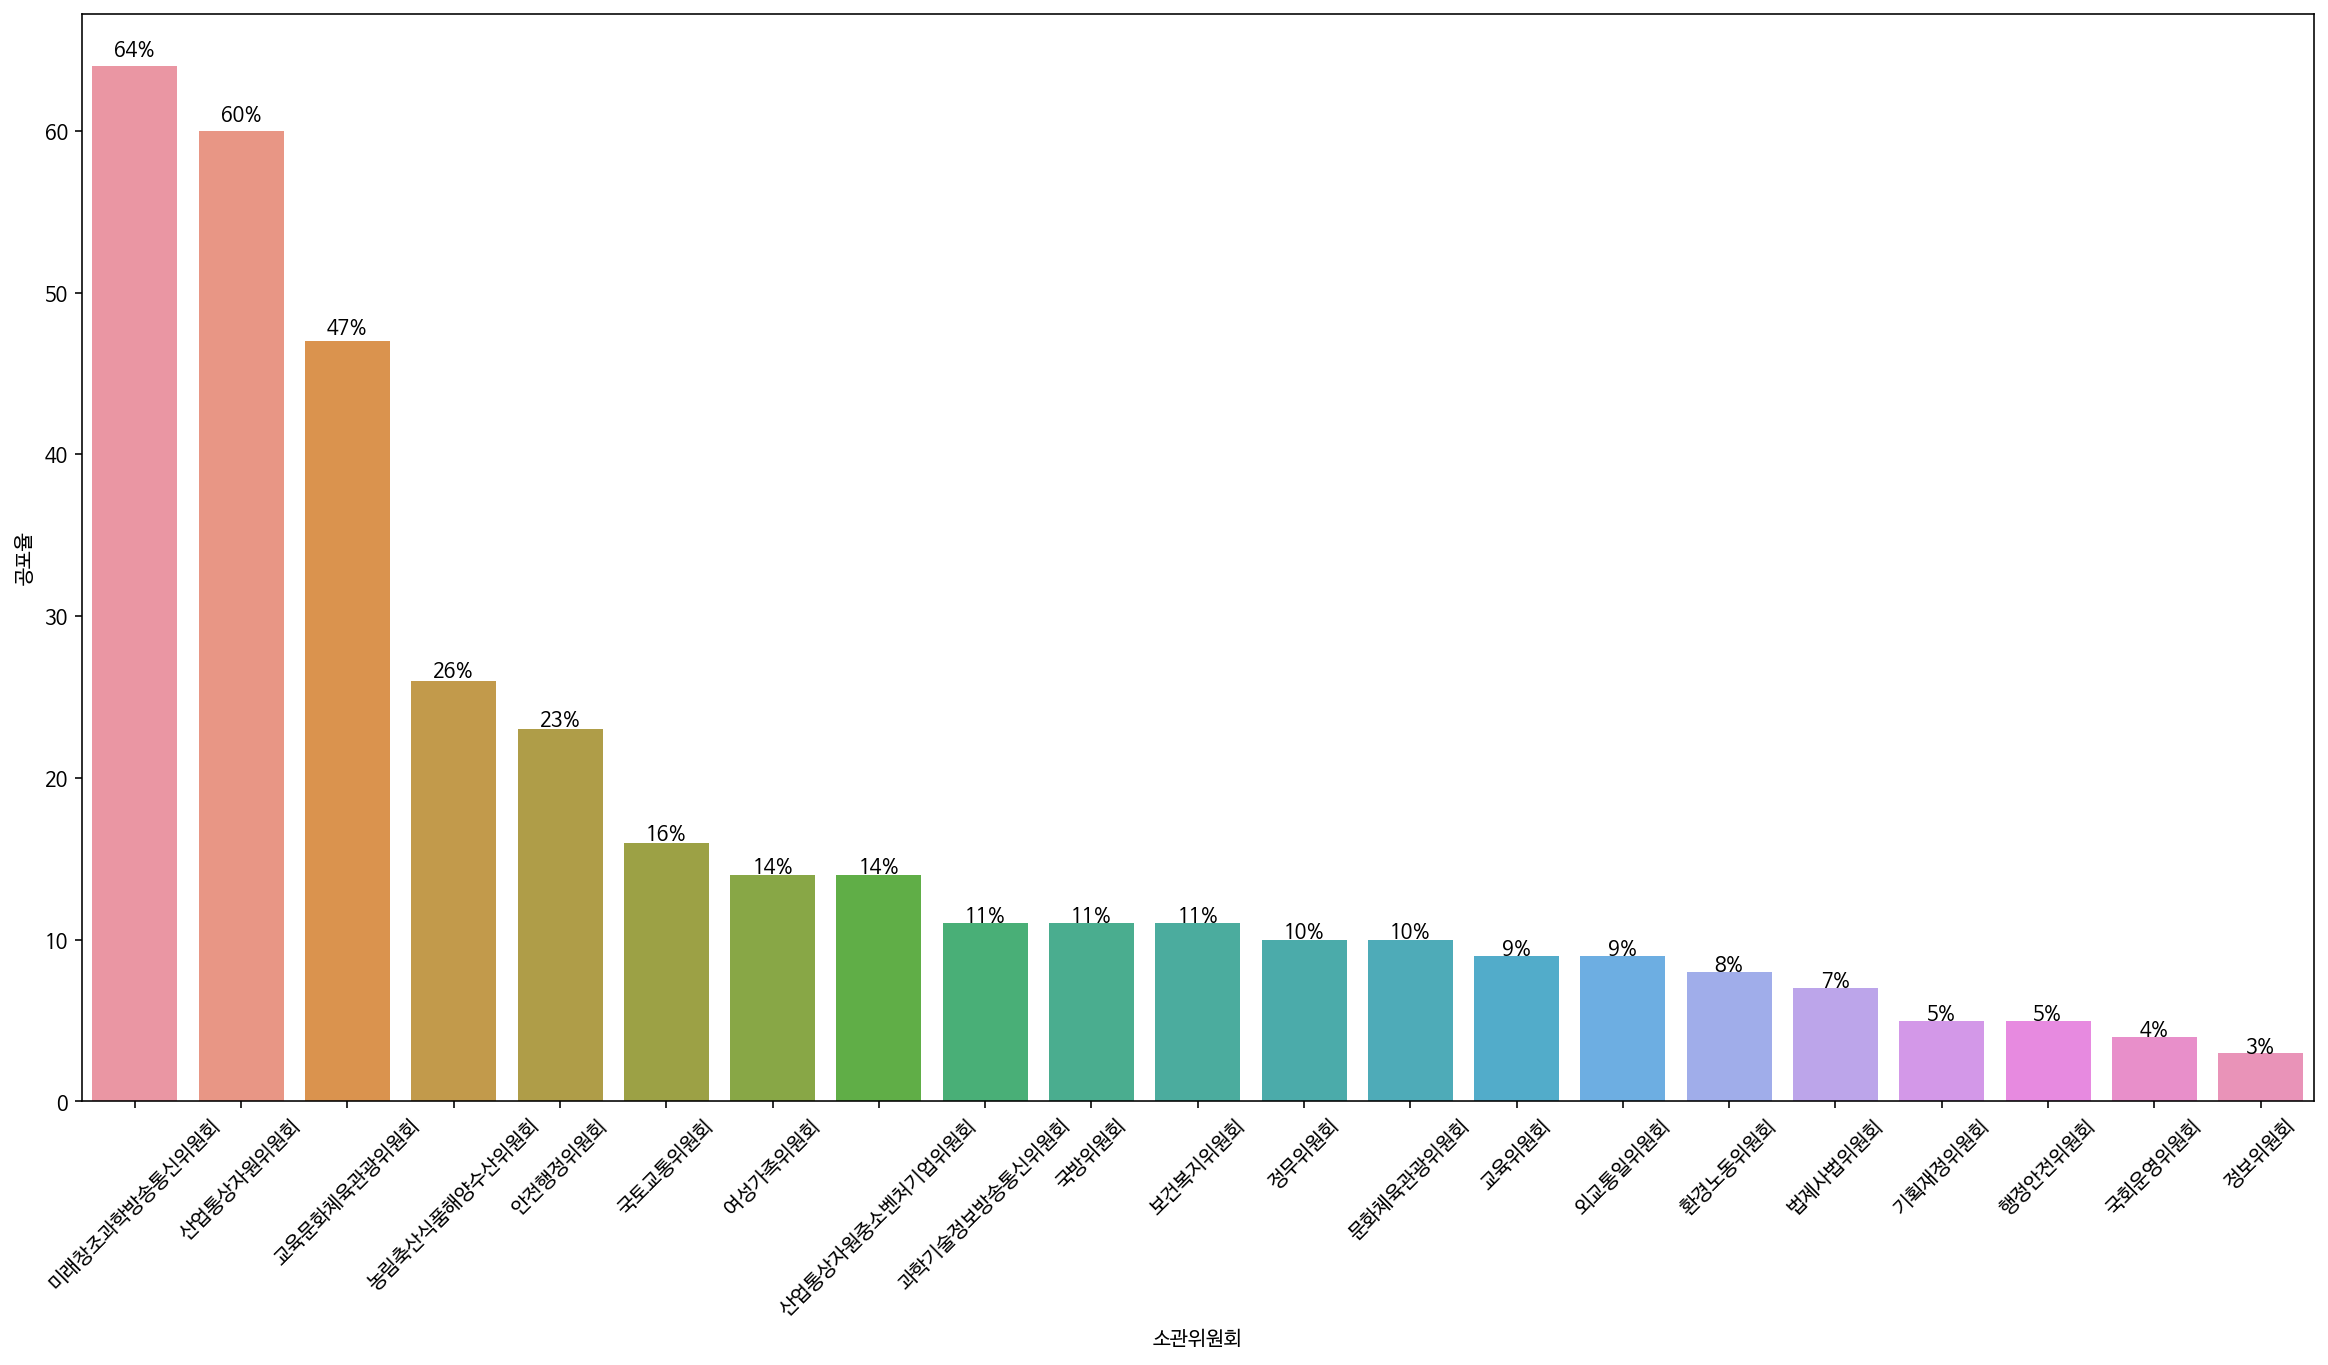

In [43]:
def commsum_vis(df): 
    order = list(comm_df2.sort_values(by='공포율', ascending=False)['소관위원회'].unique())
    
    plt.figure(figsize = (20,10))
    plt.xticks(rotation = 45)
    ax = sns.barplot(x='소관위원회', y='공포율', data=df, order = order)
    
    for p in ax.patches: 
        left, bottom, width, height = p.get_bbox().bounds 
        ax.annotate("%.1d%%" % (height), (left+width/2, height*1.01), ha='center')
    
    plt.show()
    
commsum_vis(comm_df2.sort_values(by='합계', ascending=False))

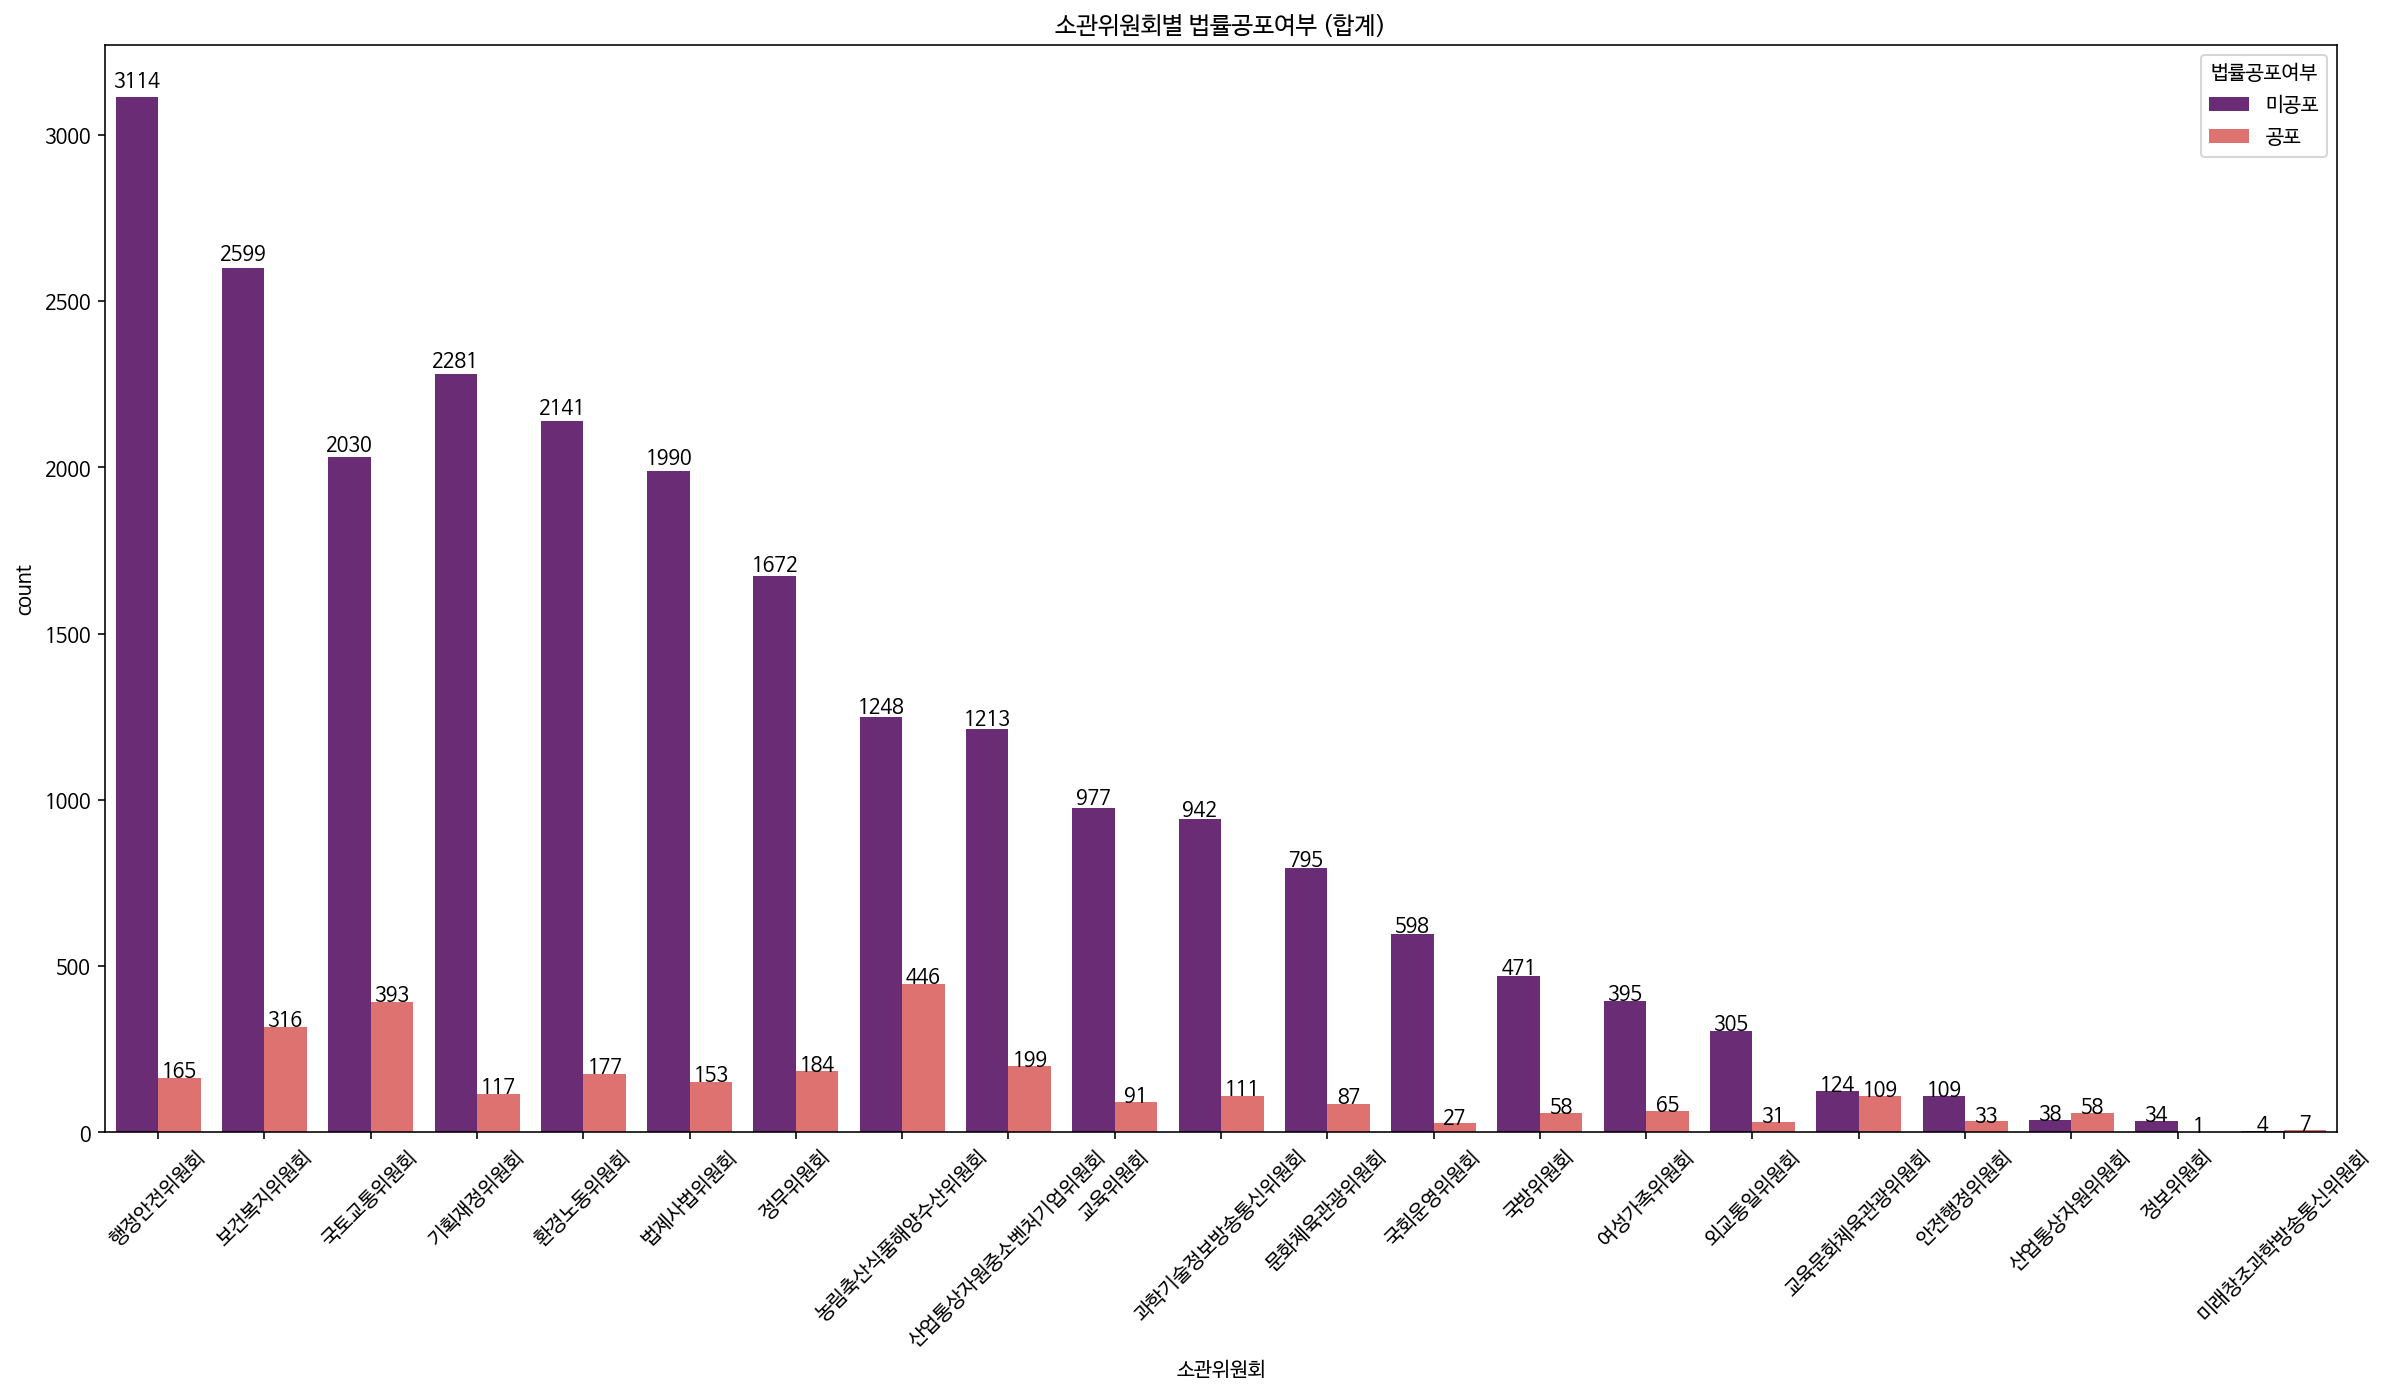

In [44]:
# 의안수 합계 정렬 
order = list(comm_df2.sort_values(by='합계', ascending=False)['소관위원회'].unique())
plt.figure(figsize = (20,10))
plt.xticks(rotation = 45)
ax = sns.countplot(x = '소관위원회', hue = '법률공포여부', data = comm_df1, 
              palette = 'magma', order = order)
plt.title('소관위원회별 법률공포여부 (합계)')

for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%.1d"%(height), (left+width/2, height*1.01), ha='center')
    
plt.show()

In [45]:
# 국회의원들의 관심도를 드러내는 것이 맞을까? 이렇게 많이 발의했다면? 
comm_df2.sort_values(by='합계', ascending=False)

,소관위원회,공포,미공포,합계,공포율
19,행정안전위원회,165,3114,3279,5.0
11,보건복지위원회,316,2599,2915,11.0
4,국토교통위원회,393,2030,2423,16.0
6,기획재정위원회,117,2281,2398,5.0
20,환경노동위원회,177,2141,2318,8.0
10,법제사법위원회,153,1990,2143,7.0
17,정무위원회,184,1672,1856,10.0
7,농림축산식품해양수산위원회,446,1248,1694,26.0
13,산업통상자원중소벤처기업위원회,199,1213,1412,14.0
2,교육위원회,91,977,1068,9.0


## 젠더 폭력 분야 법안 분석

- 시간대별 법안 발의 분석도 함께!



In [46]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [47]:
def billdate_vis(df, name): 
    date = pd.DataFrame(df.groupby('제안일자')['의안번호'].count())
    plt.figure(figsize = (30,6))
    plt.xticks(rotation = - 45)
    sns.pointplot(data = date, x=date.index, y='의안번호')
    plt.title(f'월별 {name} 관련 법안 발의 건수', fontsize=25)
    
def party_vis(df): 
    partylist = get_party(df)
    party_df = pd.DataFrame(df[partylist].sum(), columns=['발의횟수']).sort_values('발의횟수', ascending=False)
    party_df.plot(kind='barh', grid=True, figsize=(8,8))
    plt.show()
    
def billresult(bill_df, event_df): 
    df = pd.pivot_table(event_df, 
                        index=['법률반영여부', '의결결과'],
                        values=['의결처리기간']).fillna(0)
    tmp = event_df['의결결과'].value_counts()
    return pd.merge(df, tmp, left_on='의결결과', right_index=True)

def proornot_vis(df, name): 
    plt.figure(figsize = (5,5))
    plt.xticks(rotation = 45)
    ax = sns.countplot(x = '법률공포여부', data = df, 
              palette = 'magma')

    for p in ax.patches: 
        left, bottom, width, height = p.get_bbox().bounds 
        ax.annotate("%.1d"%(height), (left+width/2, height*1.01), ha='center')

    plt.title(f'{name} 사건 관련 의안 공포 여부')
    plt.show()
    
def partypro_vis(df1, df2, df3, df4): 
    hue_order = ['공포','미공포']
    
    # 첫번째 plot 
    plt.subplot(2,2,1)
    plt.xticks(rotation = 45)
    ax = sns.countplot(x = df1.columns[0], hue = '법률공포여부', data = df1, 
                  palette = 'coolwarm', hue_order = hue_order)
    for p in ax.patches: 
        left, bottom, width, height = p.get_bbox().bounds 
        try: 
            ax.annotate("%.1d"%(height), (left+width/2, height*1.01), ha='center')
        except: 
            pass 
    
    # 두번째 plot 
    plt.subplot(2,2,2)
    plt.xticks(rotation = 45)
    ax = sns.countplot(x = df2.columns[0], hue = '법률공포여부', data = df2, 
                  palette = 'coolwarm', hue_order = hue_order)
    for p in ax.patches: 
        left, bottom, width, height = p.get_bbox().bounds 
        try: 
            ax.annotate("%.1d"%(height), (left+width/2, height*1.01), ha='center')
        except:
            pass
    
    # 세번째 plot 
    plt.subplot(2,2,3)
    plt.xticks(rotation = 45)
    ax = sns.countplot(x = df3.columns[0], hue = '법률공포여부', data = df3, 
                  palette = 'coolwarm', hue_order = hue_order)
    for p in ax.patches: 
        left, bottom, width, height = p.get_bbox().bounds 
        try: 
            ax.annotate("%.1d"%(height), (left+width/2, height*1.01), ha='center')
        except: 
            pass 

    # 네번째 plot 
    plt.subplot(2,2,4)
    plt.xticks(rotation = 45)
    ax = sns.countplot(x = df4.columns[0], hue = '법률공포여부', data = df4, 
                  palette = 'coolwarm', hue_order = hue_order)
    for p in ax.patches: 
        left, bottom, width, height = p.get_bbox().bounds 
        try: 
            ax.annotate("%.1d"%(height), (left+width/2, height*1.01), ha='center')
        except: 
            pass
    
    plt.subplots_adjust(right=1.5)
    # plt.subplots_adjust(bottom=0.5)
    plt.subplots_adjust(top=2, hspace=0.25)
    # plt.title('소관위원회별 법률공포여부 (합계)')
    plt.show()

### 젠더 폭력 의안 전처리 

In [48]:
# 일일이 다 보고 확인해봐야 함..ㅜㅜ - 확인안했음 
keyword = r'.*(N번방|n번방|불법촬영|스토킹|데이트폭력|데이트 폭력|디지털성범죄|사이버범죄|포르노|\
                카르텔|과다노출|사이버 범죄|몰래카메라|몰카|불법 촬영|몸캠|성폭력|성착취|성매매|성범죄|\
                버닝썬|성희롱|딥페이크|복제물|음란|성범죄|n번방|웹하드|촬영물|클럽|성접대|미투|그루밍|성희롱).*'
gender = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(1016, 39)

In [49]:
# 젠더관련 의안 1016
# 총 의안수 27371
(1016 / 27371) * 100

3.7119579116583243

법률반영여부
미반영    678.834753
반영     232.979661
Name: 의결처리기간, dtype: float64 

법률공포여부
공포      64.380435
미공포    583.901266
Name: 의결처리기간, dtype: float64


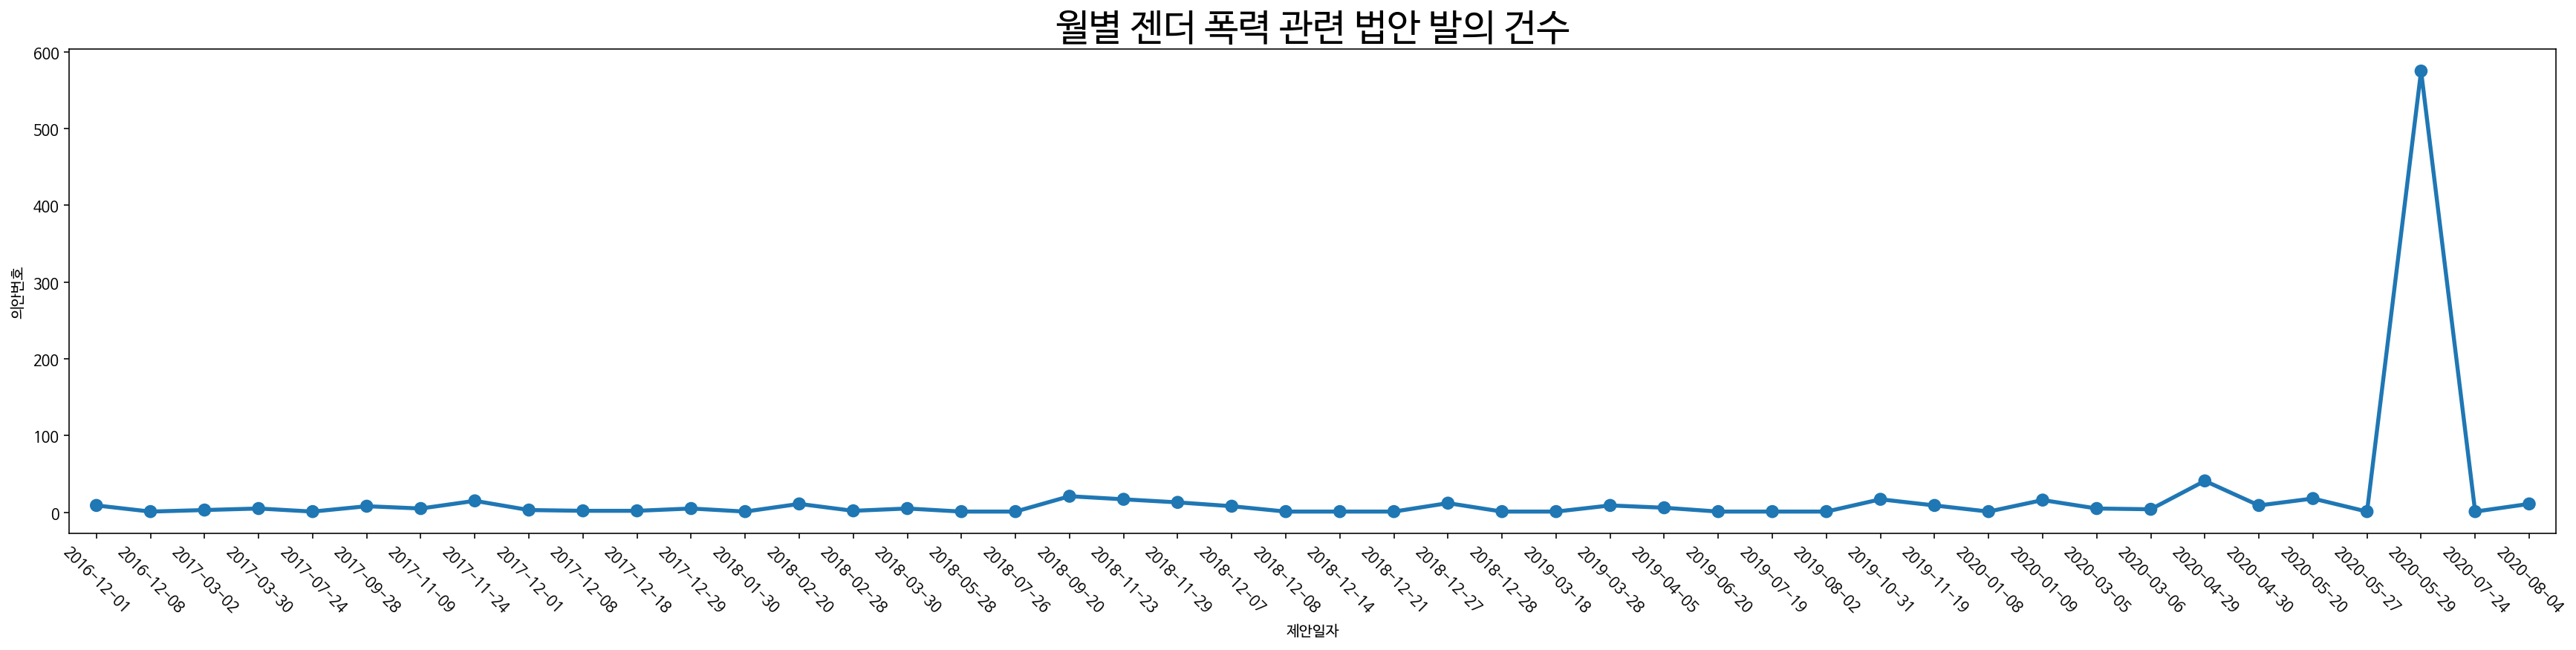

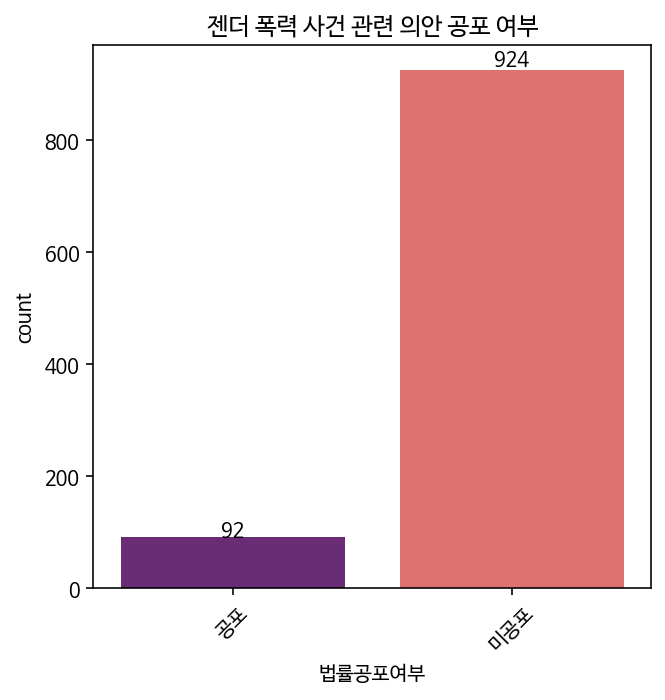

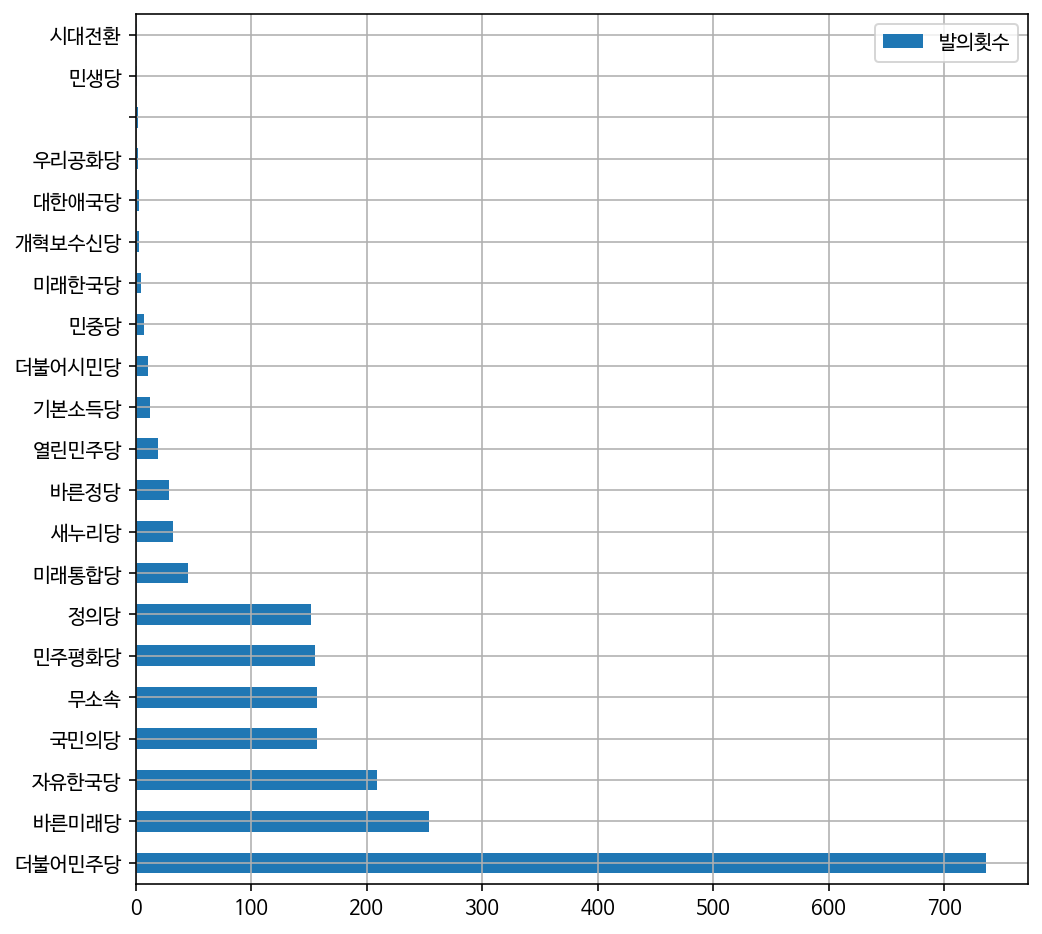

의결처리기간  의결결과
법률반영여부 의결결과                    
미반영    임기만료폐기  690.676522   575
       철회       54.000000    10
       폐기      398.500000     2
반영     대안반영폐기  309.389163   203
       수정가결    231.875000    16
       원안가결     29.118421    76

In [50]:
billdate_vis(gender, '젠더 폭력')

# 반영됐을 경우 평균 59일 소요 
print(gender['의결처리기간'].groupby(gender['법률반영여부']).mean(), '\n')

# 공포시까지 4일 소요됨 but 공포된 법안은 11개! 
print(gender['의결처리기간'].groupby(gender['법률공포여부']).mean())

proornot_vis(gender, '젠더 폭력')

party_vis(gender)

billresult(bill_df, gender)

법률공포여부
공포      49.0
미공포    687.0
Name: 더불어민주당, dtype: float64
법률공포여부
공포       3.0
미공포    251.0
Name: 바른미래당, dtype: float64
법률공포여부
공포      23.0
미공포    186.0
Name: 자유한국당, dtype: float64
법률공포여부
공포       2.0
미공포    150.0
Name: 정의당, dtype: float64


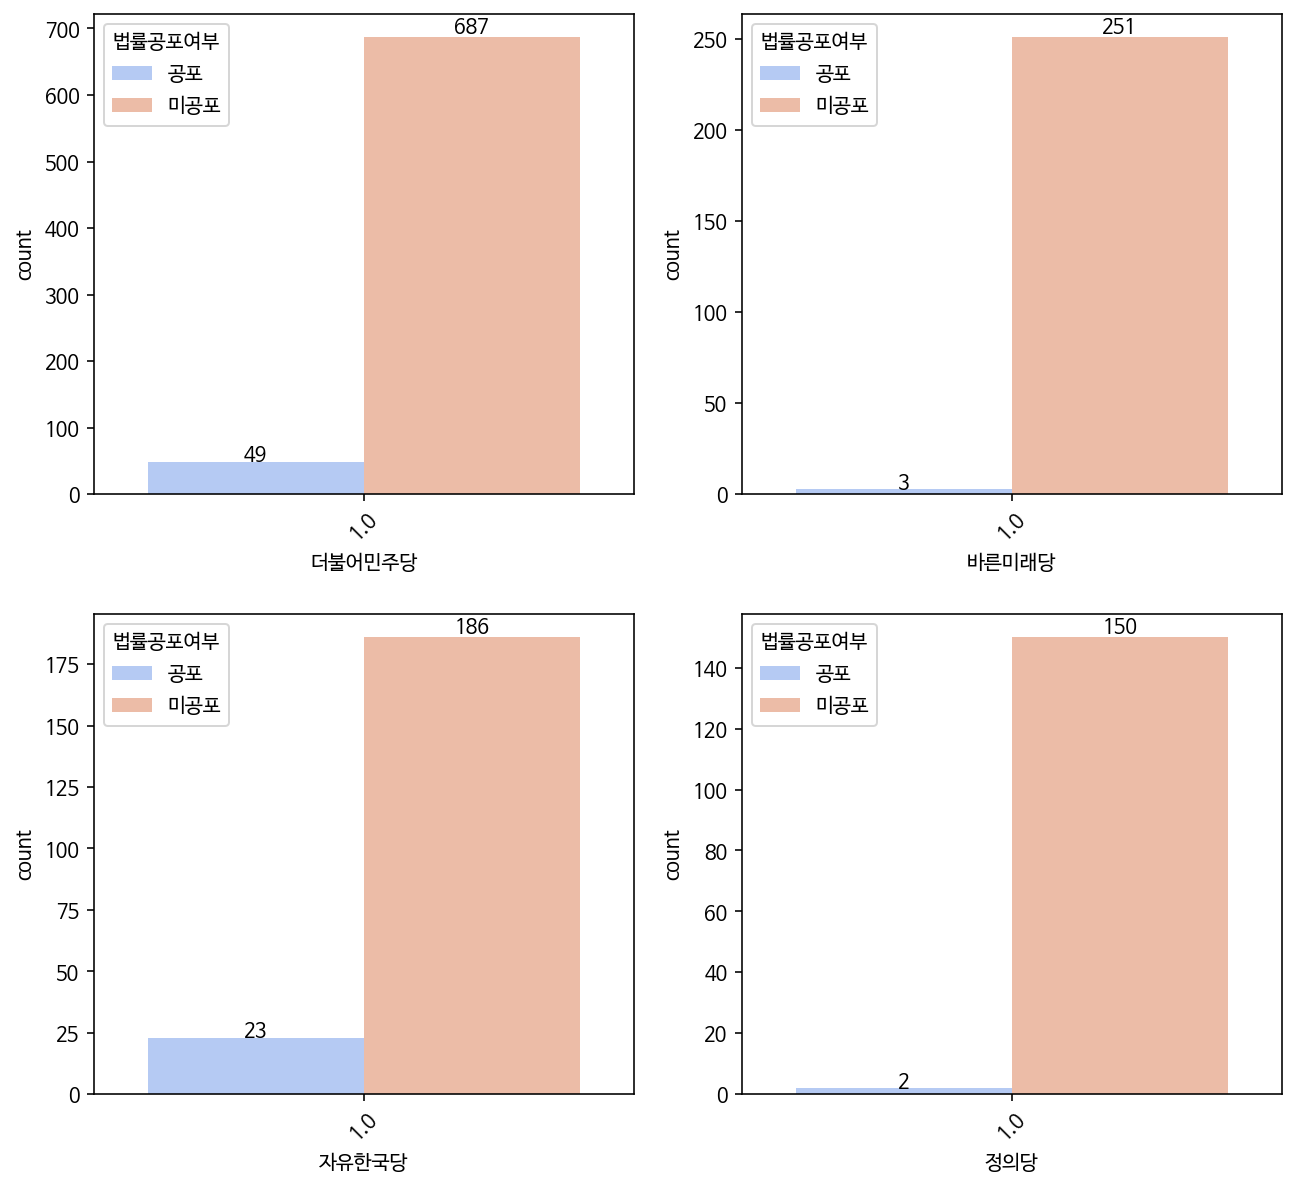

In [51]:
party1 = gender[gender['더불어민주당'] == 1][['더불어민주당','법률공포여부']]
party2 = gender[gender['바른미래당'] == 1][['바른미래당','법률공포여부']]
party3 = gender[gender['자유한국당'] == 1][['자유한국당','법률공포여부']]
party4 = gender[gender['정의당'] == 1][['정의당','법률공포여부']]

print(party1.groupby('법률공포여부')['더불어민주당'].sum())
print(party2.groupby('법률공포여부')['바른미래당'].sum())
print(party3.groupby('법률공포여부')['자유한국당'].sum())
print(party4.groupby('법률공포여부')['정의당'].sum())

partypro_vis(party1, party2, party3, party4)

### 2. n번방 관련 법안

- 딥페이크, 불법촬영 포함
- 실질적으로 N번방 관련 사건이 대두된 것은 2019년 9월 추적단 불꽃의 최초 보도. 그 이후의 법안만 분석해야 할까? (일단은 그 전까지도 모두 담아놓았음) 

In [52]:
# 의안번호 2014046 2018년 먼저 다크웹 규제 강화 법안 발의 but 임기만료폐기 
keyword = r'.*(N번방|성착취|불법촬영|복제물|불법 촬영|n번방|음란|채팅앱|웹하드|촬영물|텔레그램|디지털성범죄|박사방|디지털 성범죄|사이버범죄|사이버 범죄|포르노|딥페이크|딥 페이크|deep).*'
nthroom = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]

removeNum = [2024225, 2021888, 2020682, 2020673, 2020205, 2019791, 2018969, 2017840, 2017312, 
             2016562, 2015078, 2010841, 2010400, 2010381, 2009122, 2008869, 2007883, 2007326, 
            2007016, 2006449, 2005983, 2004587, 2004534, 2004397, 2003987, 2003968, 2003836, 
            2002649, 2002150, 2101415]

nthroom = nthroom[~nthroom['의안번호'].isin(removeNum)]
nthroom = nthroom.reset_index()
nthroom = nthroom.drop('index',1)
nthroom.shape

(158, 39)

법률반영여부
미반영    496.063492
반영     218.500000
Name: 의결처리기간, dtype: float64 

법률공포여부
공포       4.363636
미공포    392.552632
Name: 의결처리기간, dtype: float64


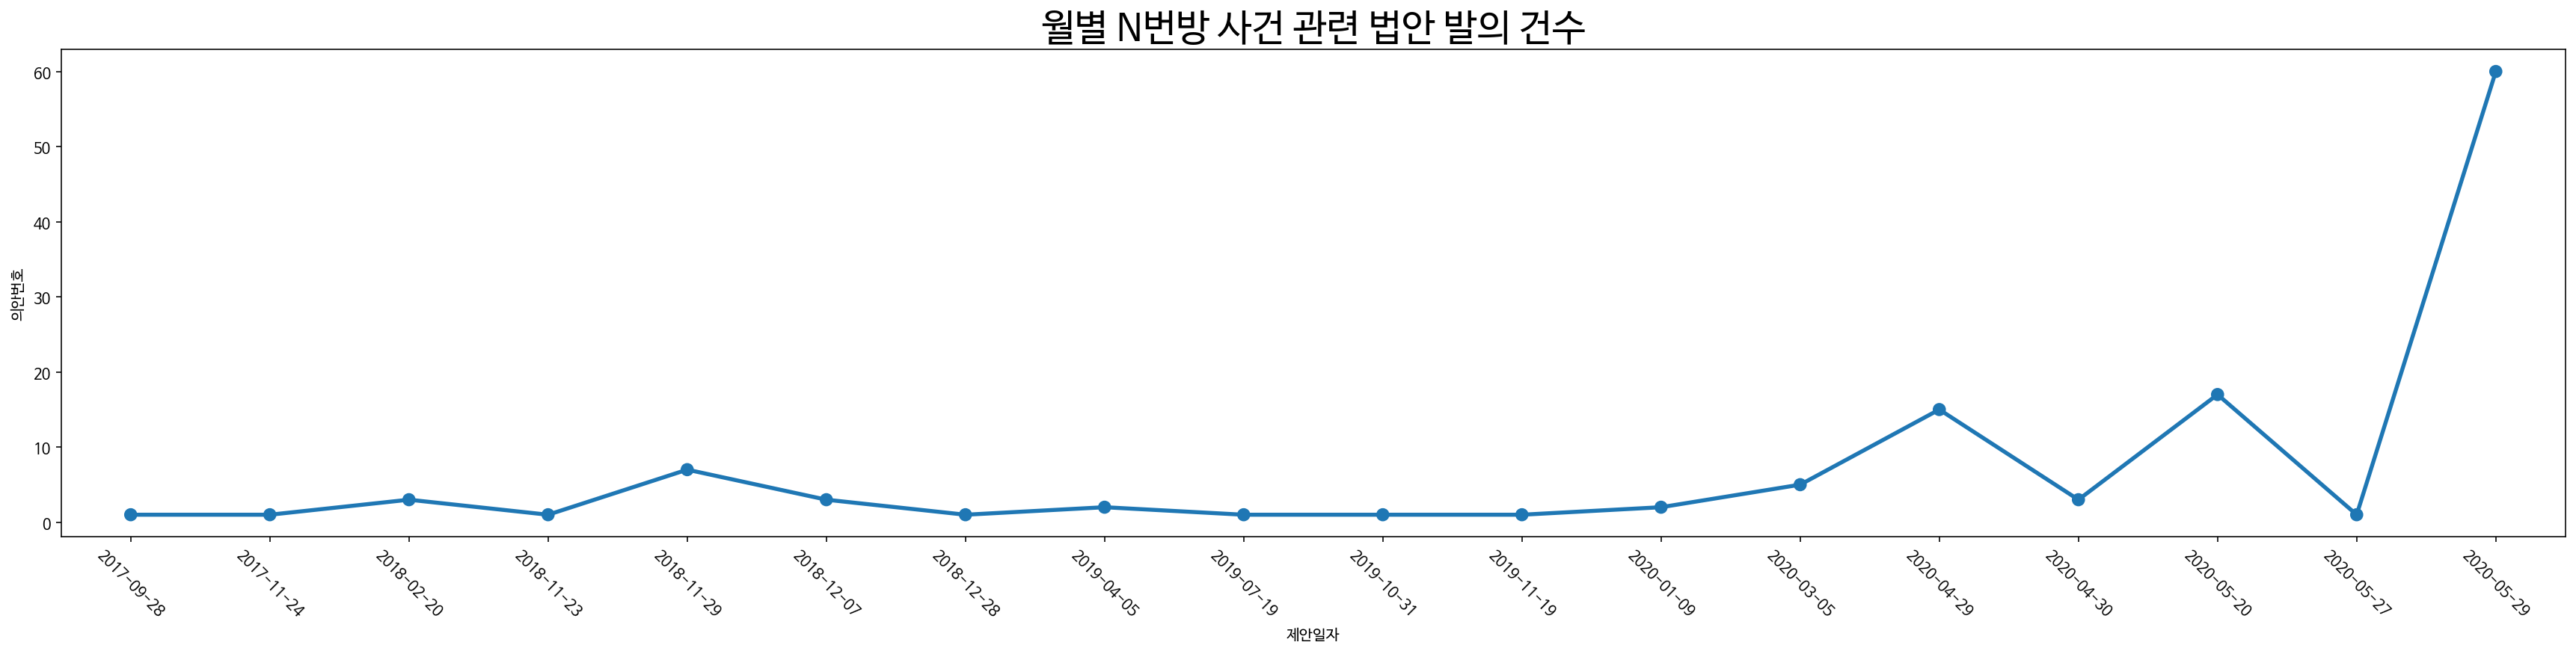

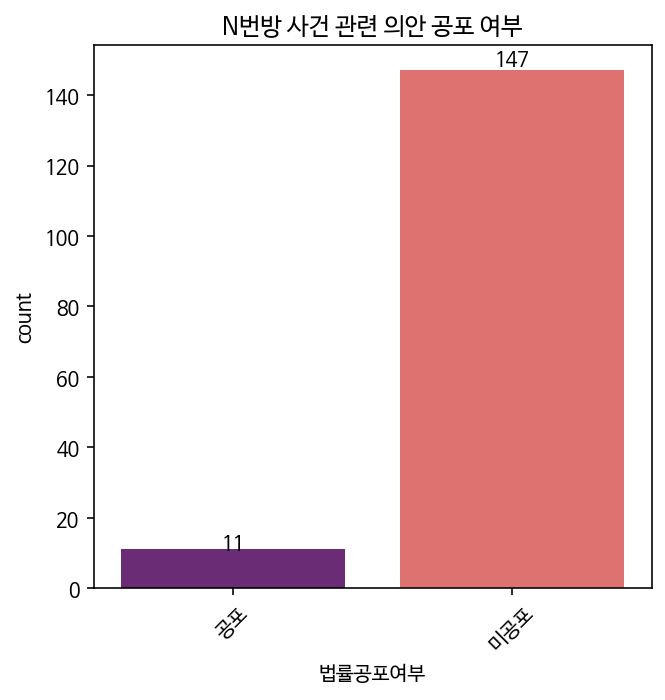

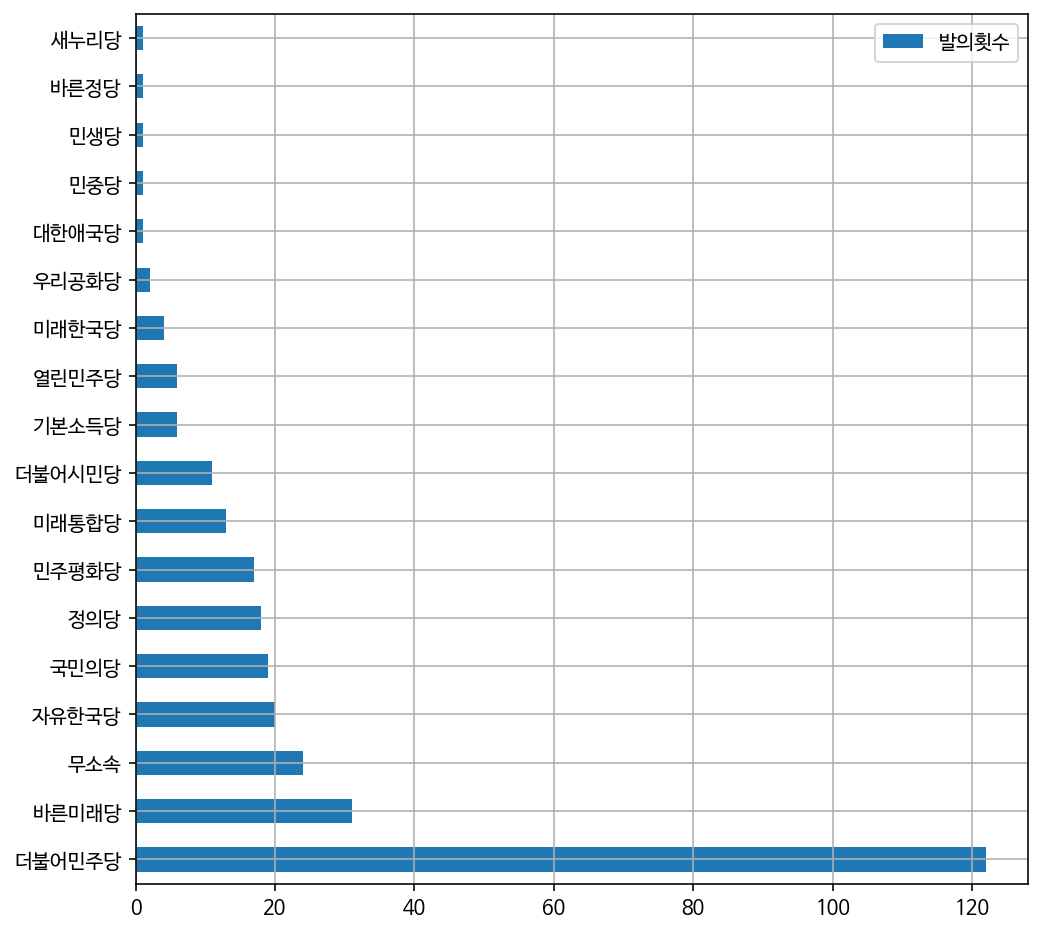

의결처리기간  의결결과
법률반영여부 의결결과                    
미반영    임기만료폐기  504.450000    60
       철회      225.500000     2
       폐기      534.000000     1
반영     대안반영폐기  264.686275    51
       원안가결      4.363636    11

In [53]:
billdate_vis(nthroom, 'N번방 사건')

# 반영됐을 경우 평균 59일 소요 
print(nthroom['의결처리기간'].groupby(nthroom['법률반영여부']).mean(), '\n')

# 공포시까지 4일 소요됨 but 공포된 법안은 11개! 
print(nthroom['의결처리기간'].groupby(nthroom['법률공포여부']).mean())

proornot_vis(nthroom, 'N번방')

party_vis(nthroom)

billresult(bill_df, nthroom)

법률공포여부
공포       7.0
미공포    115.0
Name: 더불어민주당, dtype: float64
법률공포여부
미공포    31.0
Name: 바른미래당, dtype: float64
법률공포여부
미공포    20.0
Name: 자유한국당, dtype: float64
법률공포여부
미공포    18.0
Name: 정의당, dtype: float64


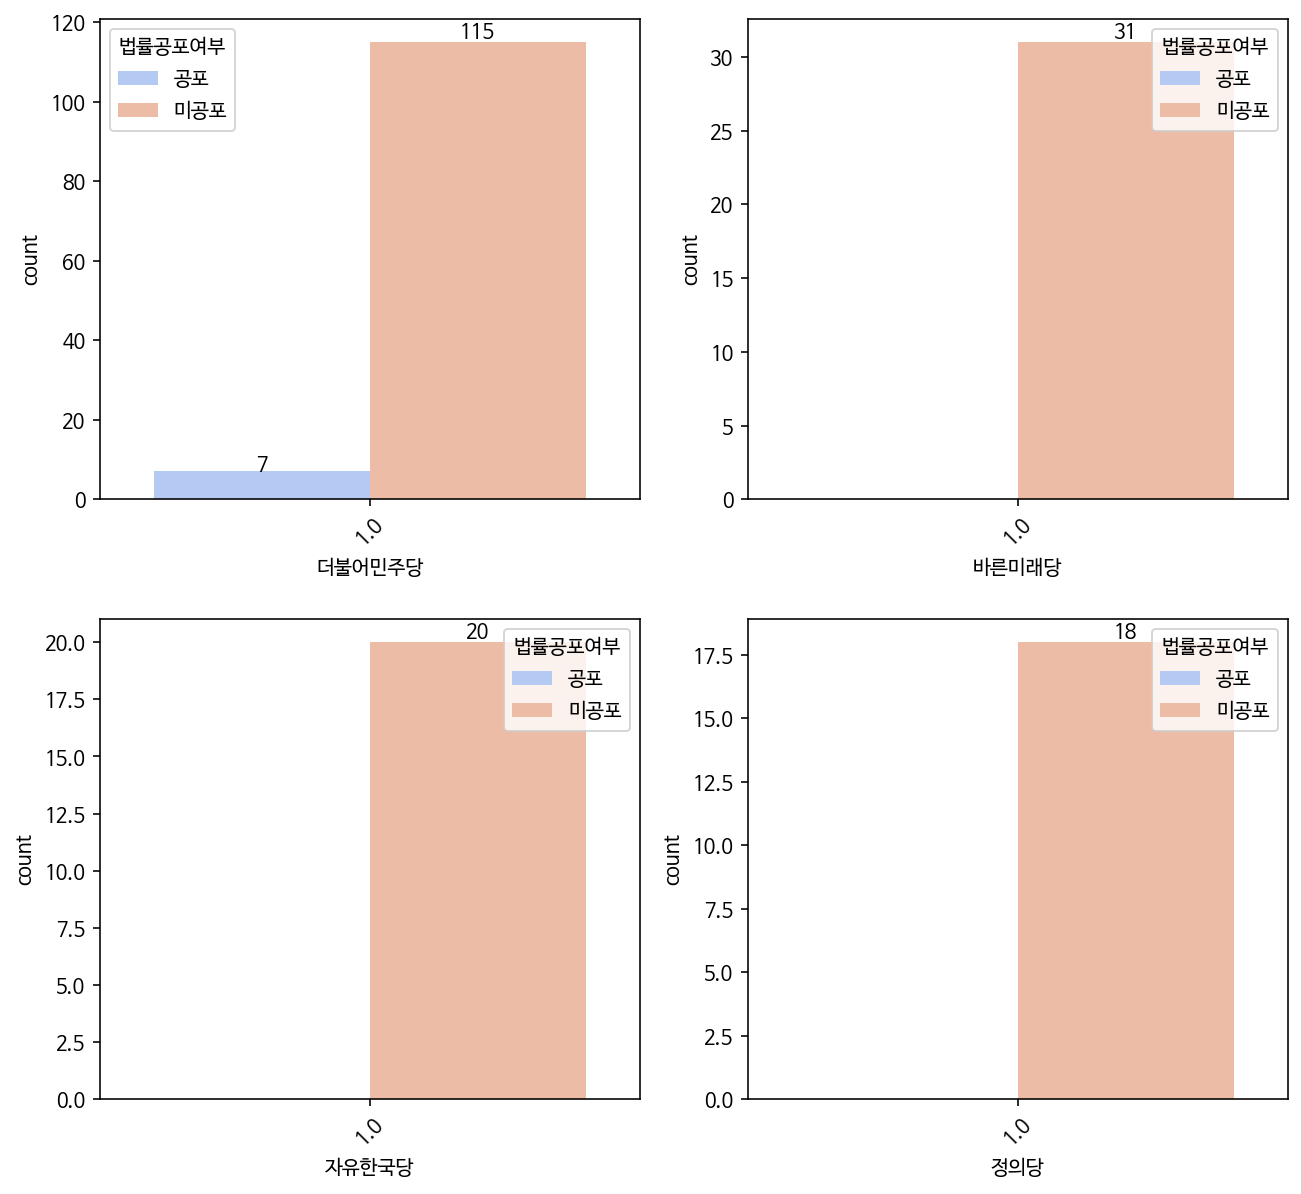

In [54]:
party1 = nthroom[nthroom['더불어민주당'] == 1][['더불어민주당','법률공포여부']]
party2 = nthroom[nthroom['바른미래당'] == 1][['바른미래당','법률공포여부']]
party3 = nthroom[nthroom['자유한국당'] == 1][['자유한국당','법률공포여부']]
party4 = nthroom[nthroom['정의당'] == 1][['정의당','법률공포여부']]

print(party1.groupby('법률공포여부')['더불어민주당'].sum())
print(party2.groupby('법률공포여부')['바른미래당'].sum())
print(party3.groupby('법률공포여부')['자유한국당'].sum())
print(party4.groupby('법률공포여부')['정의당'].sum())

partypro_vis(party1, party2, party3, party4)

### 불법촬영 관련 법안

- 공중화장실 관련한 법안도 포함
- 웹하드 관련 법안도 포함
- 불법촬영 관련한 교육 법안도 포함 ex) 2101733 고등교육 성폭력 예방 교육 법안
- 의안 발의의 문제일 수도 있지만, 법안을 해석하는 판사의 해석 문제일 수도. 
ex) 과다노출 해석(2005065, 2004552), 공중화장실 해석(2000056)

In [55]:
keyword = r'.*(몰래카메라|불법 복제|몰카|과다노출|웹하드|카르텔|디지털 성범죄|디지털성범죄|사이버범죄|사이버 범죄|포르노|불법 촬영|불법촬영|촬영물).*'
illegalcam = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]

removeNum = [2023856, 2023469, 2022529, 2017602, 2014046, 2005983, 2003836] 

illegalcam = illegalcam[~illegalcam['의안번호'].isin(removeNum)]
illegalcam = illegalcam.reset_index()
illegalcam = illegalcam.drop('index',1)
illegalcam.shape

(126, 39)

법률반영여부
미반영    585.305085
반영     224.884615
Name: 의결처리기간, dtype: float64 

법률공포여부
공포       6.222222
미공포    452.656863
Name: 의결처리기간, dtype: float64


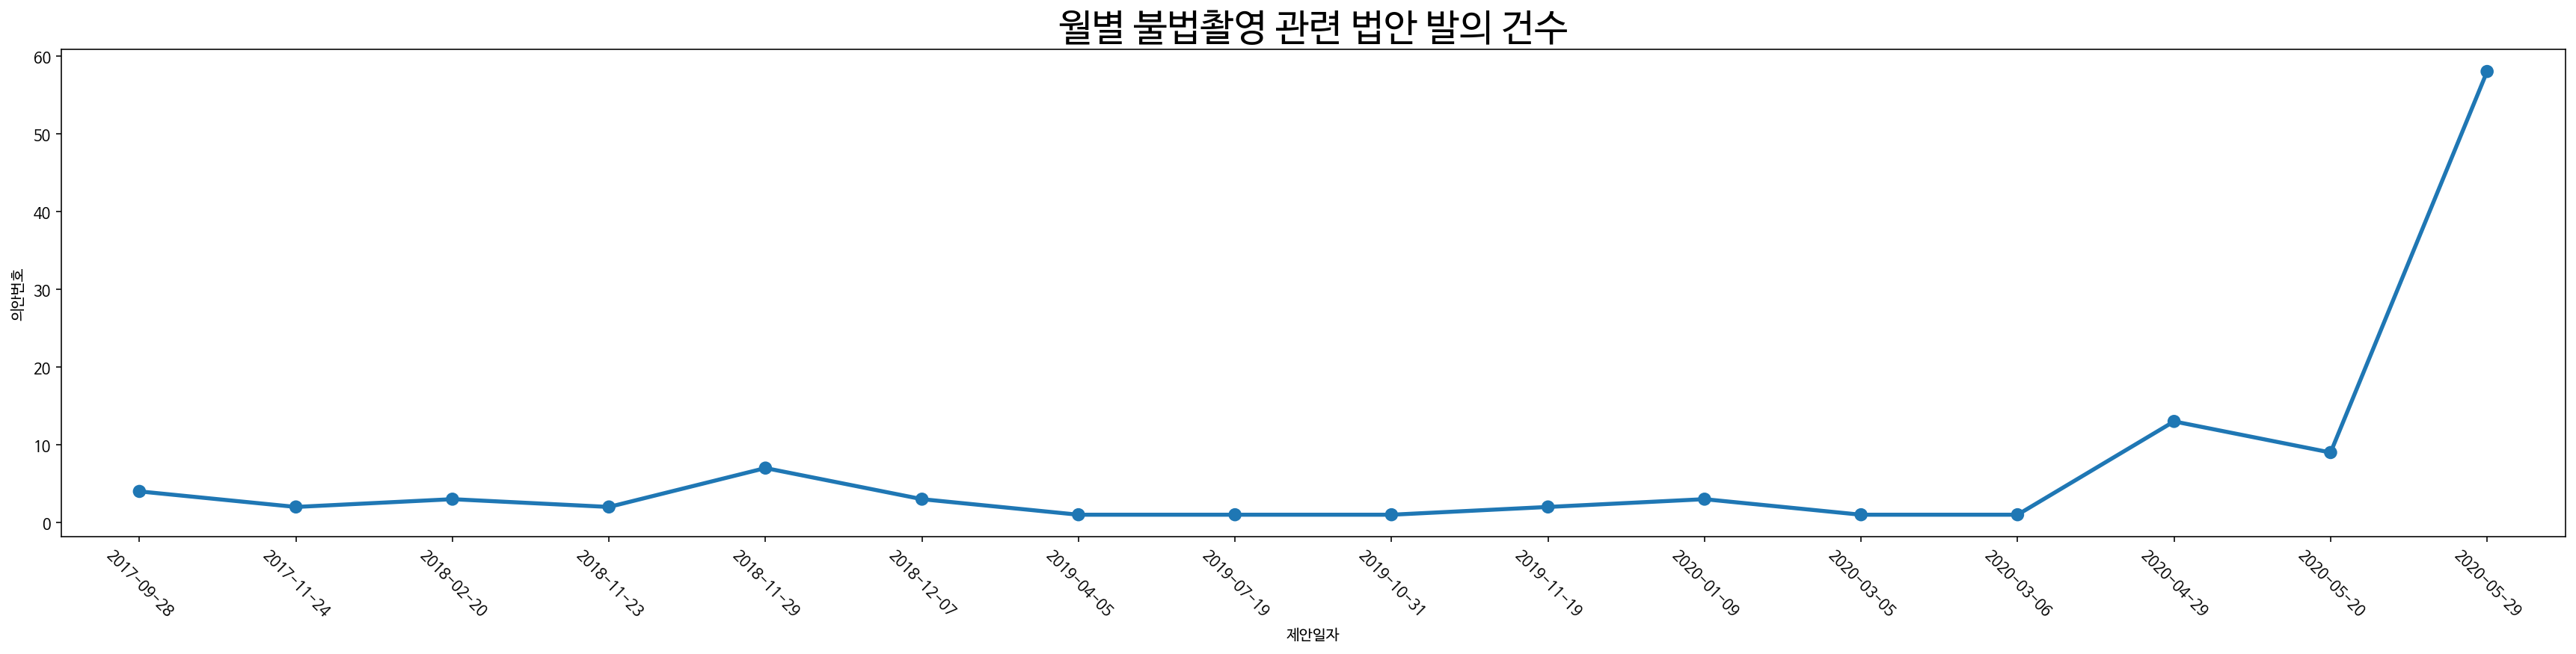

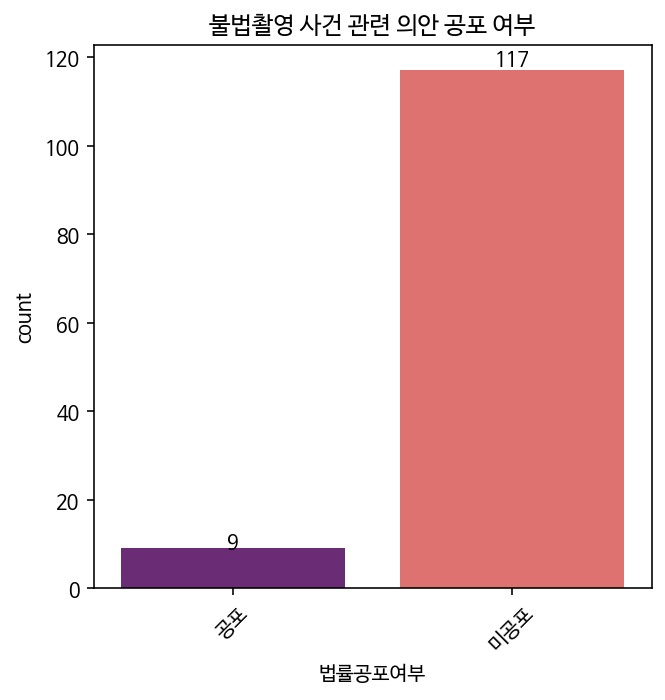

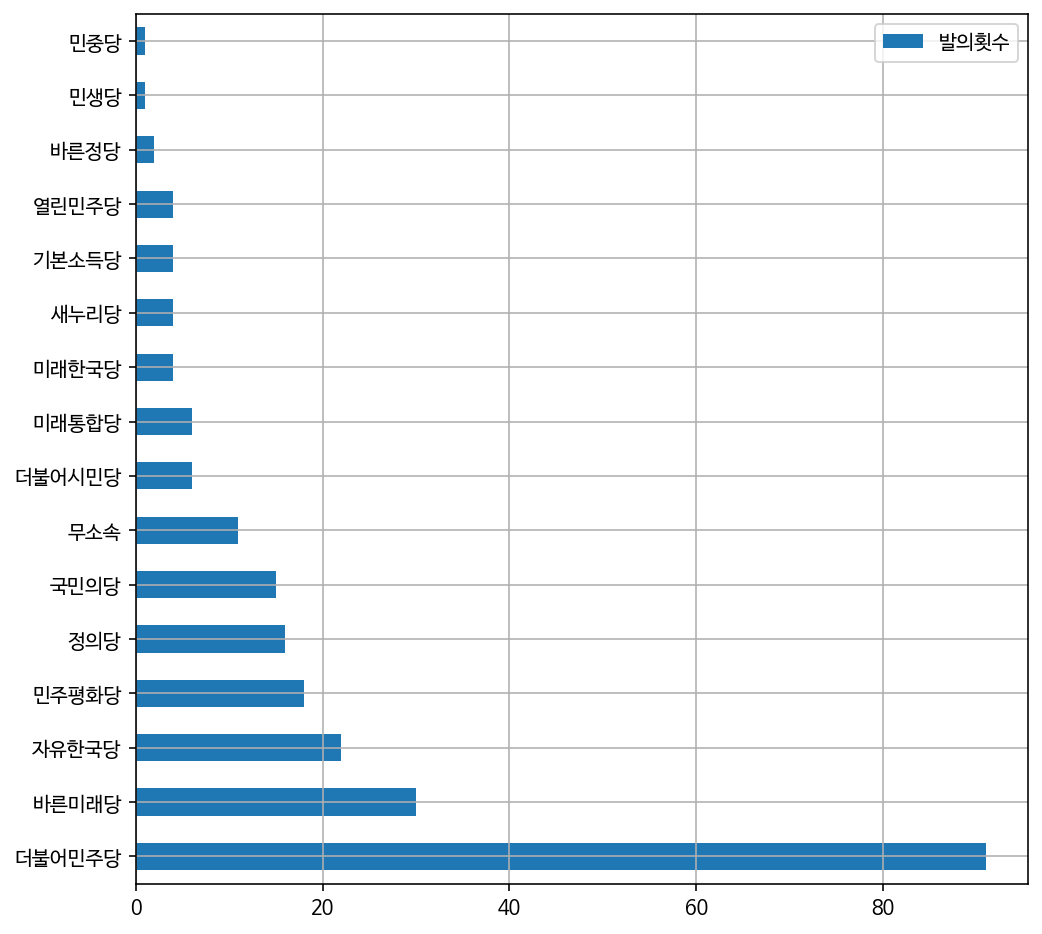

의결처리기간  의결결과
법률반영여부 의결결과                    
미반영    임기만료폐기  595.017241    58
       철회       22.000000     1
반영     대안반영폐기  270.651163    43
       원안가결      6.222222     9

In [56]:
# 월별 법안 발의 건수
billdate_vis(illegalcam, '불법촬영')

# 반영됐을 경우 평균 59일 소요 
print(illegalcam['의결처리기간'].groupby(illegalcam['법률반영여부']).mean(), '\n')

# 공포시까지 4일 소요됨 but 공포된 법안은 11개! 
print(illegalcam['의결처리기간'].groupby(illegalcam['법률공포여부']).mean())

# 사건 관련 공포 여부 합계 
proornot_vis(illegalcam, '불법촬영')

# 정당별 발의의안 횟수 
party_vis(illegalcam)

billresult(bill_df, illegalcam)

법률공포여부
공포      6.0
미공포    85.0
Name: 더불어민주당, dtype: float64
법률공포여부
미공포    30.0
Name: 바른미래당, dtype: float64
법률공포여부
공포      1.0
미공포    21.0
Name: 자유한국당, dtype: float64
법률공포여부
미공포    16.0
Name: 정의당, dtype: float64


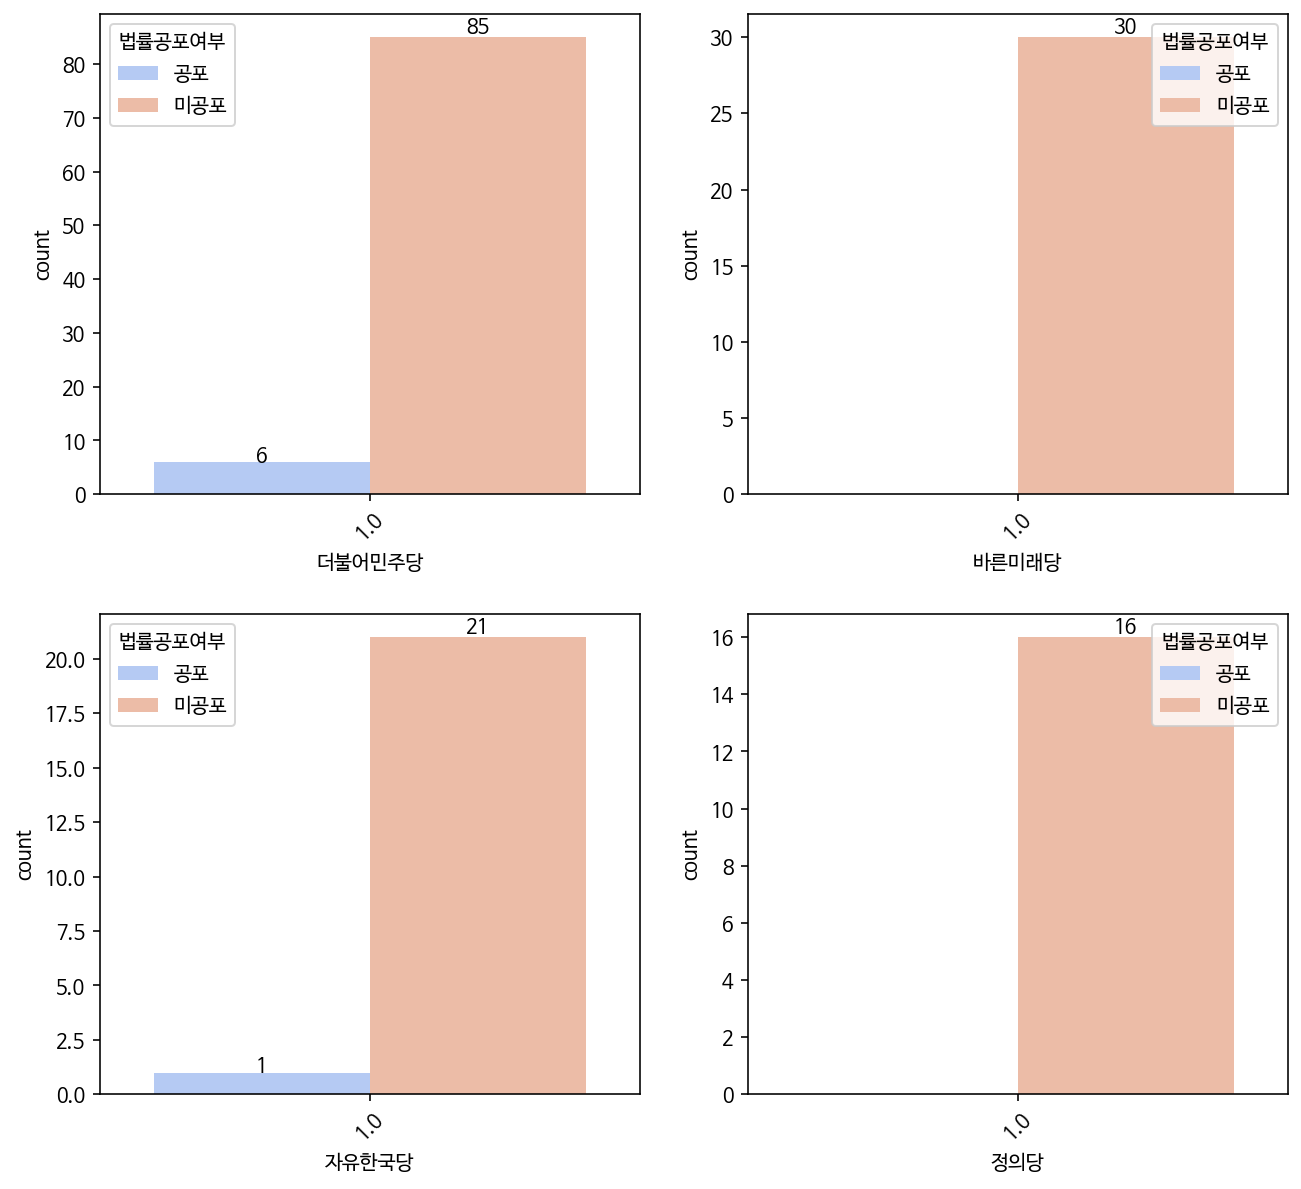

In [57]:
# 더민주, 바미당, 자한당, 정의당
party1 = illegalcam[illegalcam['더불어민주당'] == 1][['더불어민주당','법률공포여부']].fillna(0)
party2 = illegalcam[illegalcam['바른미래당'] == 1][['바른미래당','법률공포여부']].fillna(0)
party3 = illegalcam[illegalcam['자유한국당'] == 1][['자유한국당','법률공포여부']].fillna(0)
party4 = illegalcam[illegalcam['정의당'] == 1][['정의당','법률공포여부']].fillna(0)

print(party1.groupby('법률공포여부')['더불어민주당'].sum())
print(party2.groupby('법률공포여부')['바른미래당'].sum())
print(party3.groupby('법률공포여부')['자유한국당'].sum())
print(party4.groupby('법률공포여부')['정의당'].sum())

partypro_vis(party1, party2, party3, party4)

### 미투 관련 법안 

In [58]:
# 미투 법안만 추려 확인해야 하는데 확인 안 했음... 너어무 힘드러~~~
keyword = r'.*(미투|권력형 성폭력|권력형 성범죄|성희롱|성폭력|성범죄).*'
metoo = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]

removeNum = [] 

metoo = metoo[~metoo['의안번호'].isin(removeNum)]
metoo = metoo.reset_index()
metoo = metoo.drop('index',1)
metoo.shape

(894, 39)

법률반영여부
미반영    679.858509
반영     241.894531
Name: 의결처리기간, dtype: float64 

법률공포여부
공포      69.837500
미공포    589.276109
Name: 의결처리기간, dtype: float64


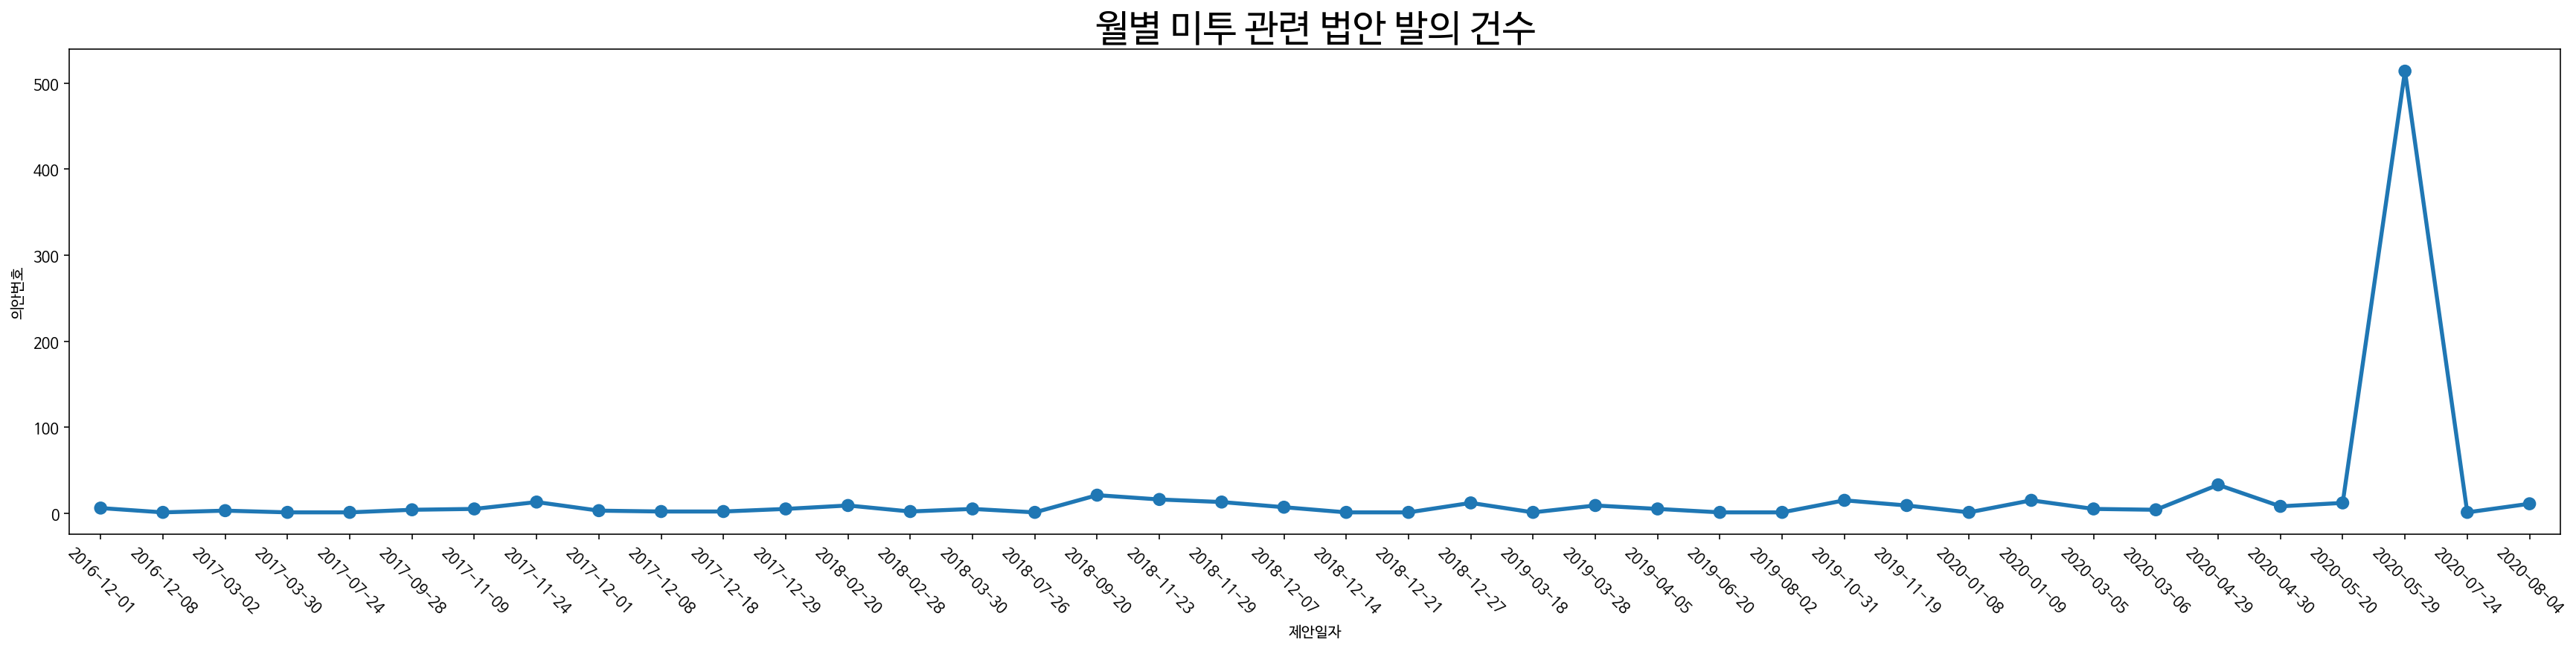

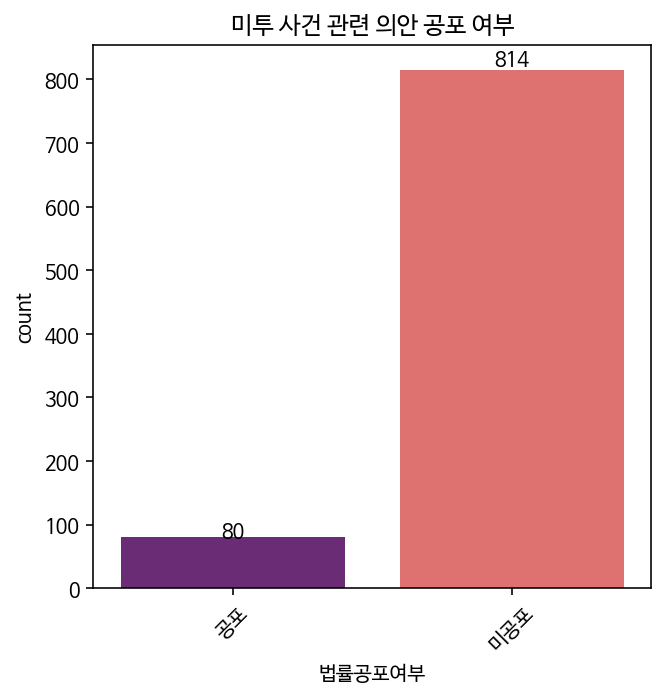

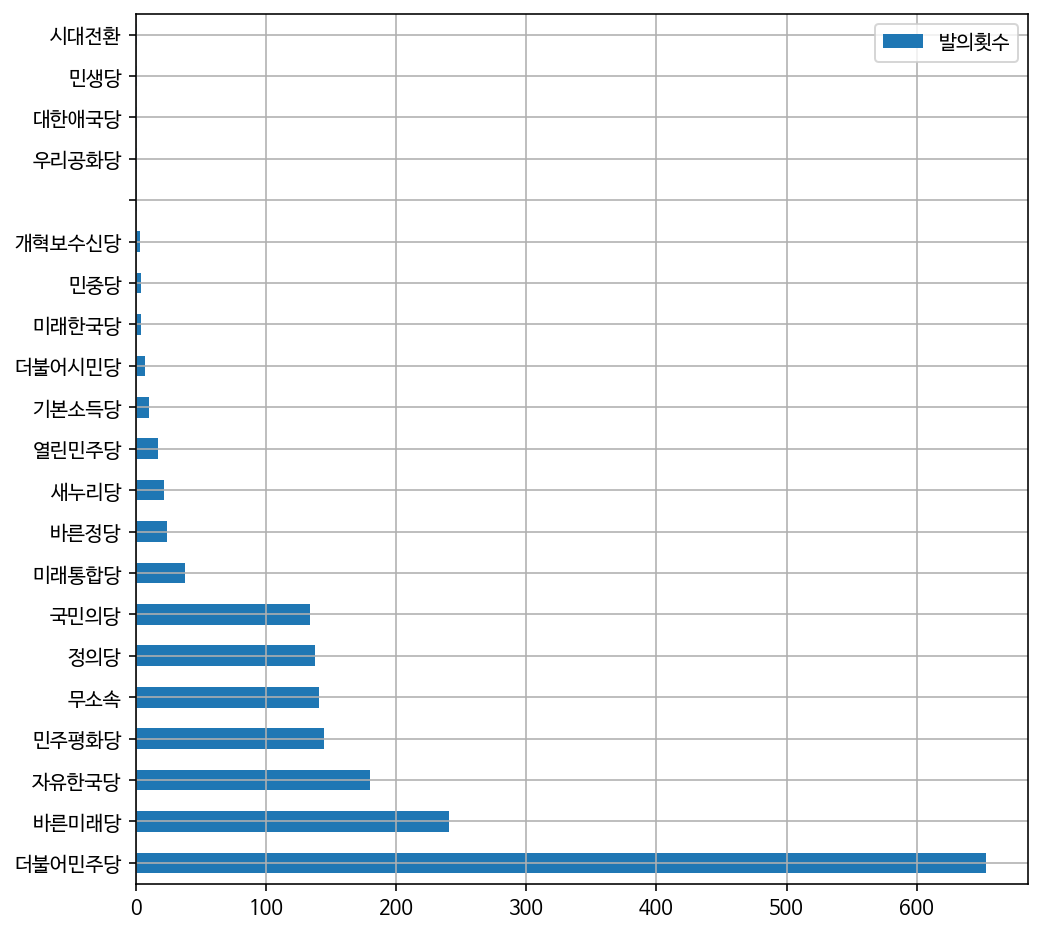

의결처리기간  의결결과
법률반영여부 의결결과                    
미반영    임기만료폐기  691.077821   514
       철회       11.125000     8
       폐기      263.000000     1
반영     대안반영폐기  320.102273   176
       수정가결    241.533333    15
       원안가결     30.215385    65

In [59]:
# 월별 법안 발의 건수
billdate_vis(metoo, '미투')

# 반영됐을 경우 평균 59일 소요 
print(metoo['의결처리기간'].groupby(metoo['법률반영여부']).mean(), '\n')

# 공포시까지 4일 소요됨 but 공포된 법안은 11개! 
print(metoo['의결처리기간'].groupby(metoo['법률공포여부']).mean())

# 사건 관련 공포 여부 합계 
proornot_vis(metoo, '미투')

# 정당별 발의의안 횟수 
party_vis(metoo)

billresult(bill_df, metoo)

법률공포여부
공포      41.0
미공포    612.0
Name: 더불어민주당, dtype: float64
법률공포여부
공포       3.0
미공포    238.0
Name: 바른미래당, dtype: float64
법률공포여부
공포      21.0
미공포    159.0
Name: 자유한국당, dtype: float64
법률공포여부
공포       2.0
미공포    136.0
Name: 정의당, dtype: float64


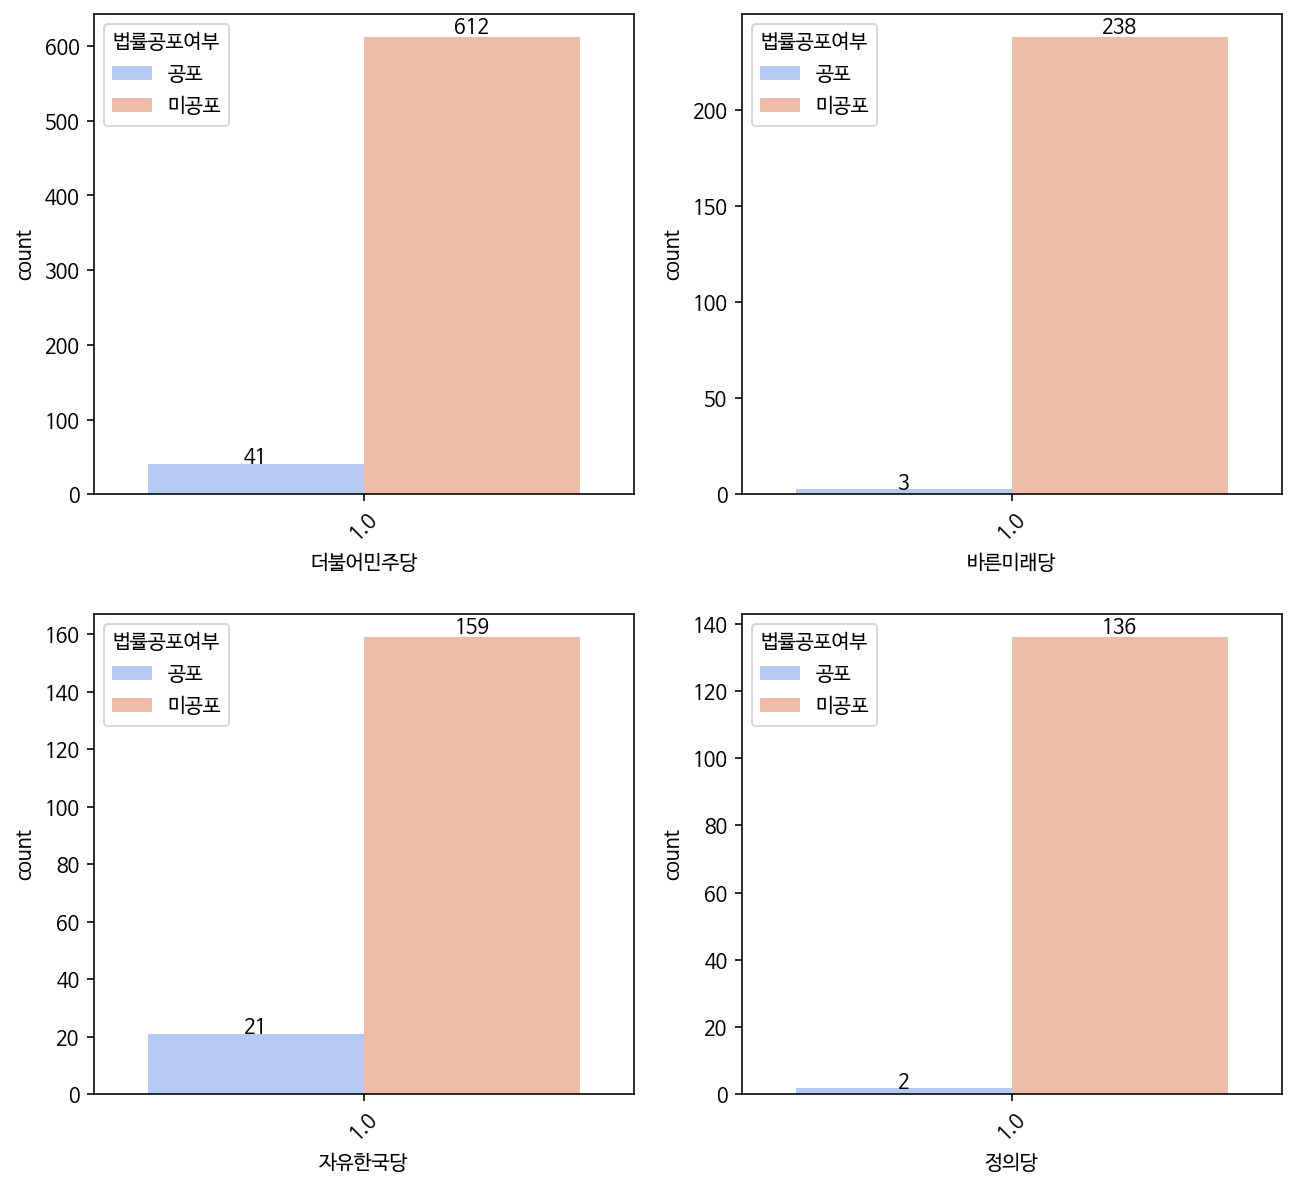

In [60]:
# 더민주, 바미당, 자한당, 정의당
party1 = metoo[metoo['더불어민주당'] == 1][['더불어민주당','법률공포여부']].fillna(0)
party2 = metoo[metoo['바른미래당'] == 1][['바른미래당','법률공포여부']].fillna(0)
party3 = metoo[metoo['자유한국당'] == 1][['자유한국당','법률공포여부']].fillna(0)
party4 = metoo[metoo['정의당'] == 1][['정의당','법률공포여부']].fillna(0)

print(party1.groupby('법률공포여부')['더불어민주당'].sum())
print(party2.groupby('법률공포여부')['바른미래당'].sum())
print(party3.groupby('법률공포여부')['자유한국당'].sum())
print(party4.groupby('법률공포여부')['정의당'].sum())

partypro_vis(party1, party2, party3, party4)

### 데이트 폭력 법안

In [61]:
keyword = r'.*(스토킹|데이트폭력|데이트 폭력|스토커).*'
stalking = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]

removeNum = [2101681]

stalking = stalking[~stalking['의안번호'].isin(removeNum)]
stalking = stalking.reset_index()
stalking = stalking.drop('index',1)
stalking.shape

(13, 39)

법률반영여부
미반영    1123.625
반영        8.000
Name: 의결처리기간, dtype: float64 

법률공포여부
미공포    999.666667
Name: 의결처리기간, dtype: float64


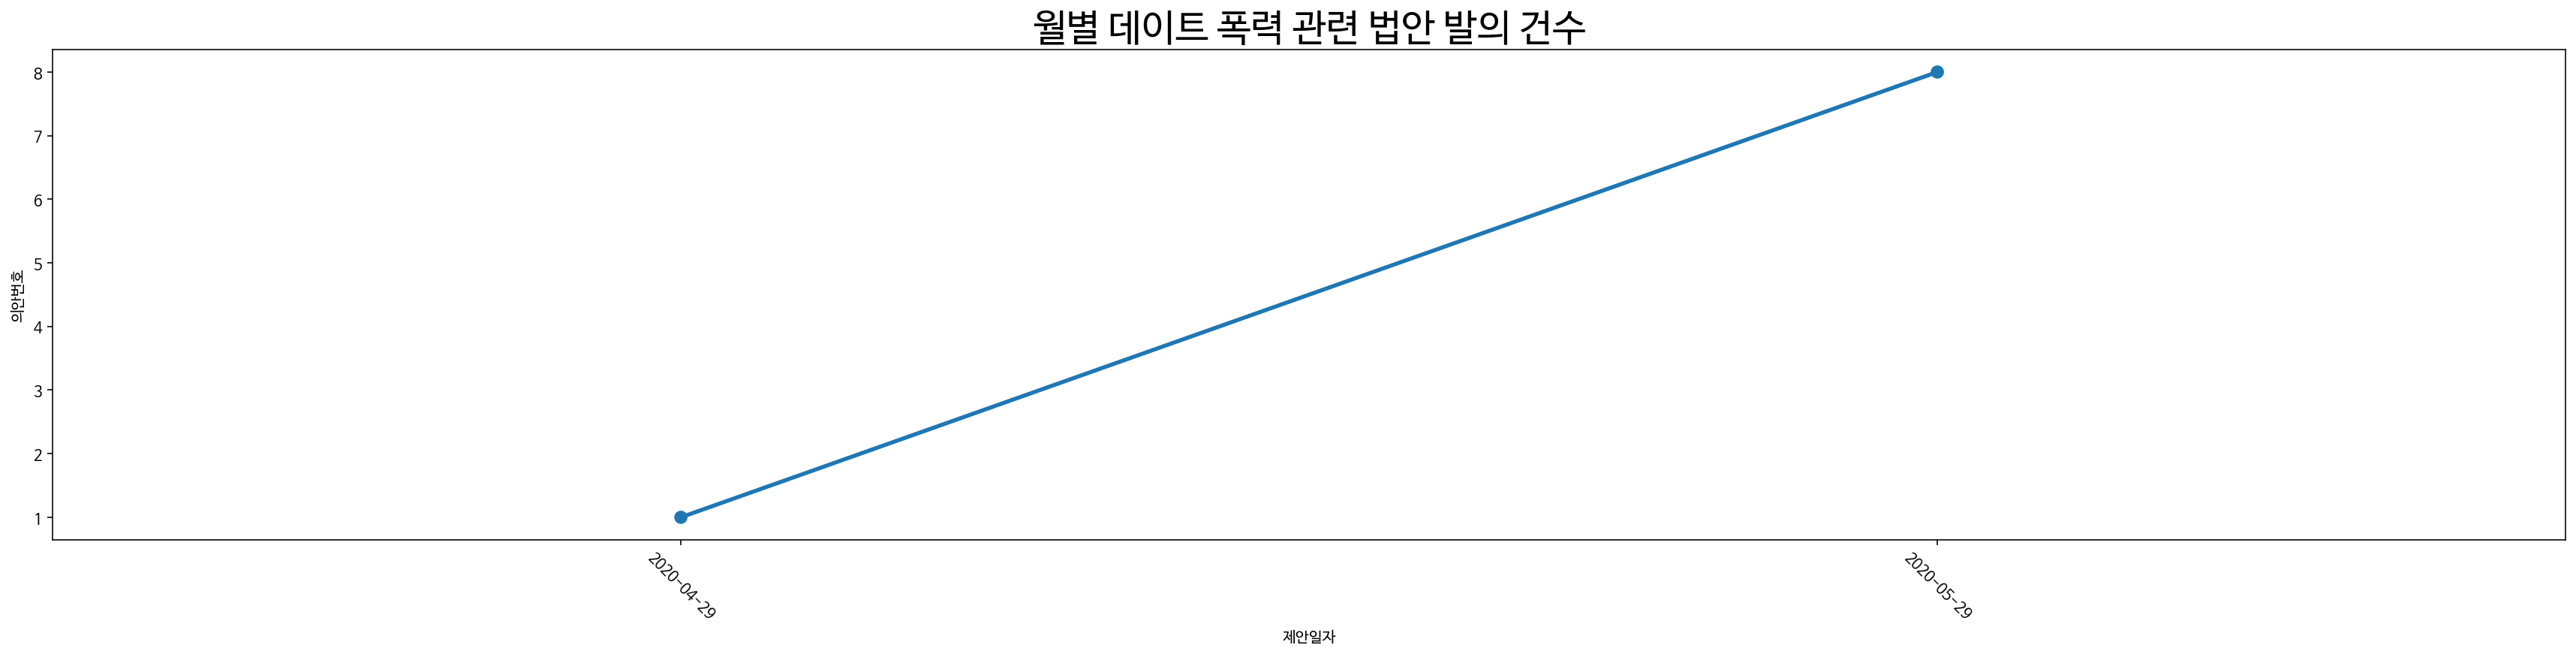

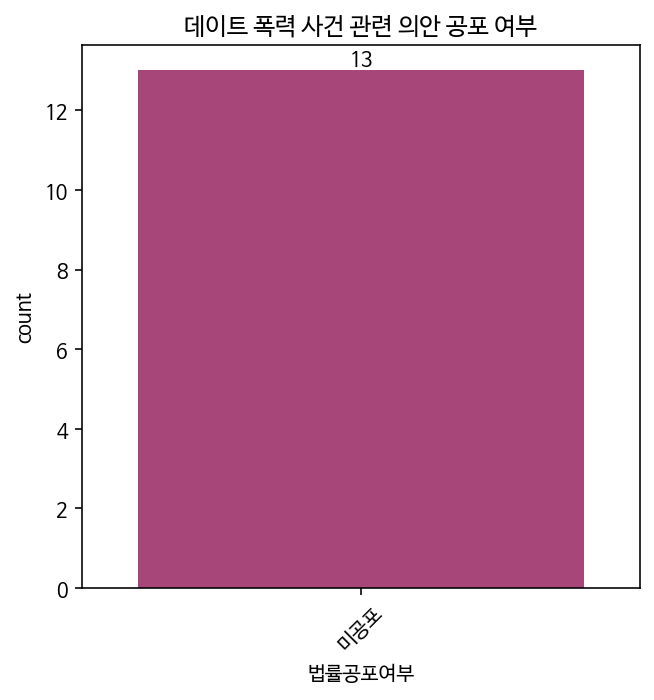

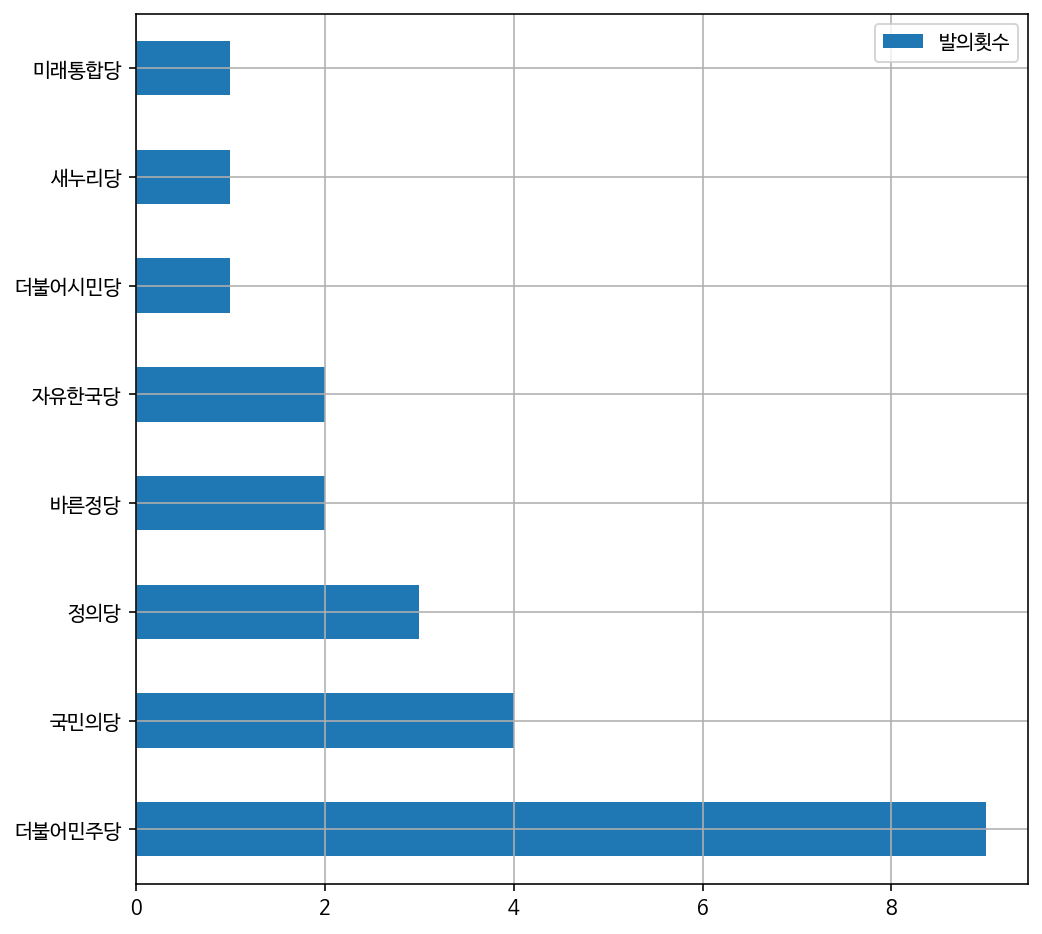

,,의결처리기간,의결결과
법률반영여부,의결결과,,
미반영,임기만료폐기,1123.625,8
반영,대안반영폐기,8.000,1


In [62]:
# 월별 법안 발의 건수
billdate_vis(stalking, '데이트 폭력')

# 반영됐을 경우 평균 59일 소요 
print(stalking['의결처리기간'].groupby(stalking['법률반영여부']).mean(), '\n')

# 공포시까지 4일 소요됨 but 공포된 법안은 11개! 
print(stalking['의결처리기간'].groupby(stalking['법률공포여부']).mean())

# 사건 관련 공포 여부 합계 
proornot_vis(stalking, '데이트 폭력')

# 정당별 발의의안 횟수 
party_vis(stalking)

billresult(bill_df, stalking)

###  딥페이크 법안

In [63]:
# 딥페이크 법안 
keyword = r'.*(딥페이크|딥 페이크|deep fake|deep).*'
deepfake = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]

deepfake = deepfake.reset_index()
deepfake = deepfake.drop('index',1)
deepfake.shape

(10, 39)

법률반영여부
미반영    179.000000
반영      84.666667
Name: 의결처리기간, dtype: float64 

법률공포여부
공포       0.500000
미공포    144.166667
Name: 의결처리기간, dtype: float64


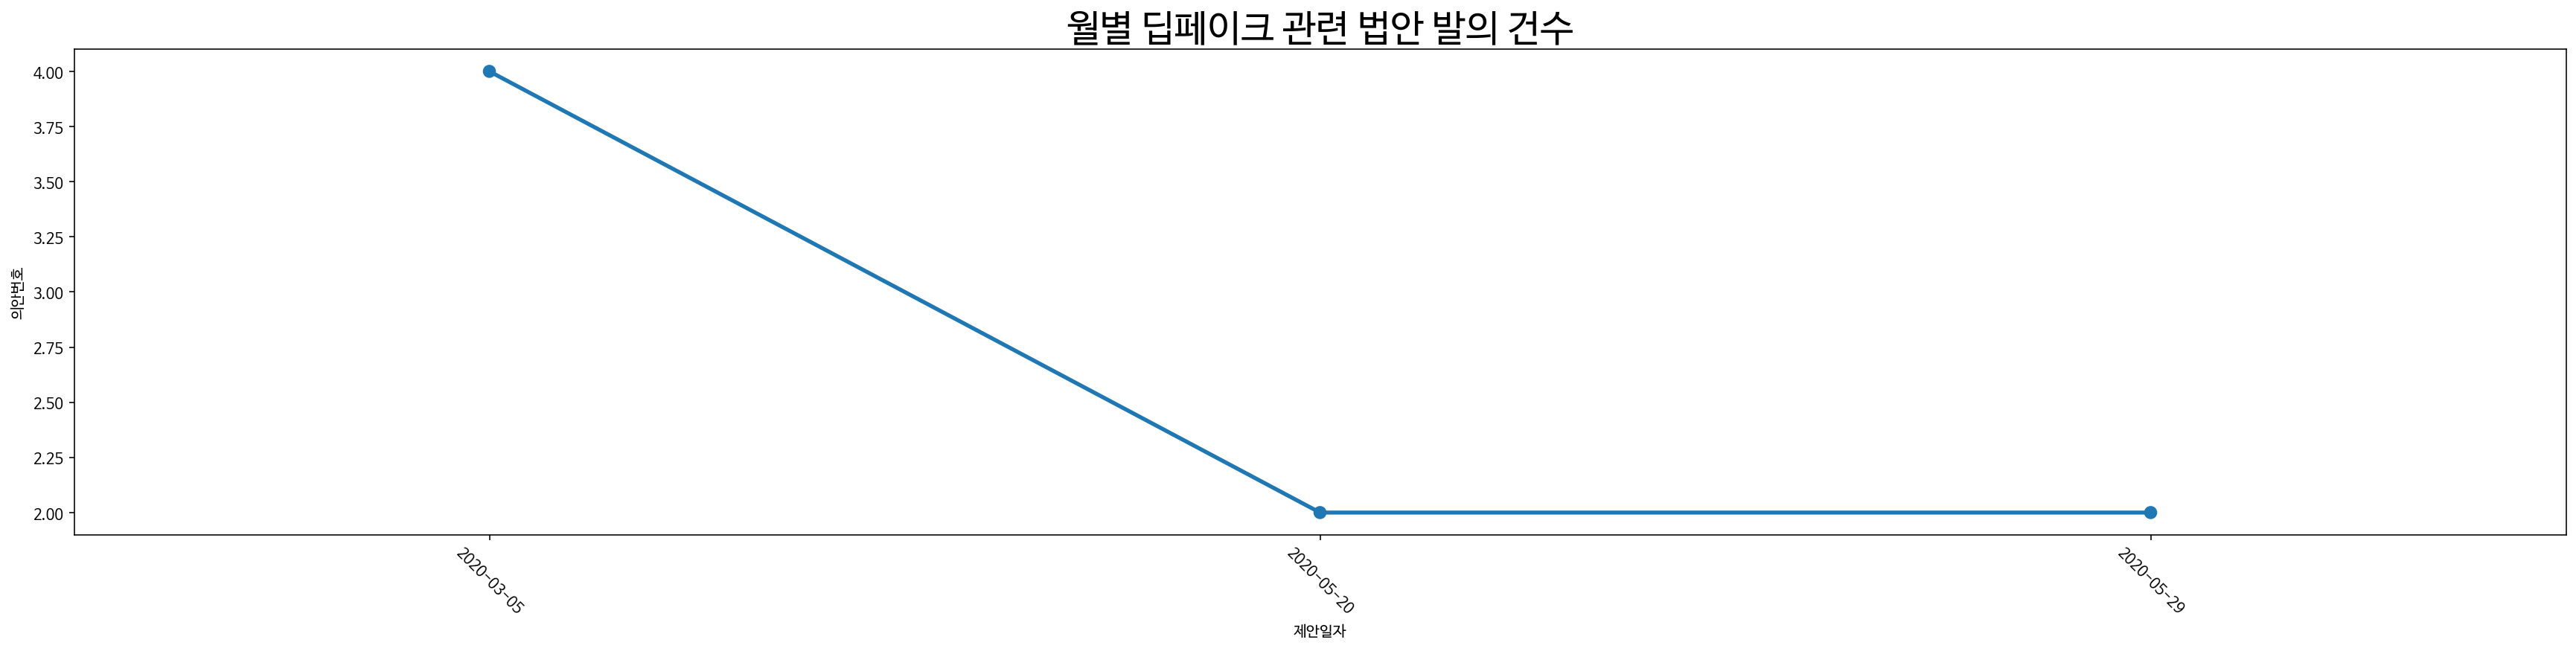

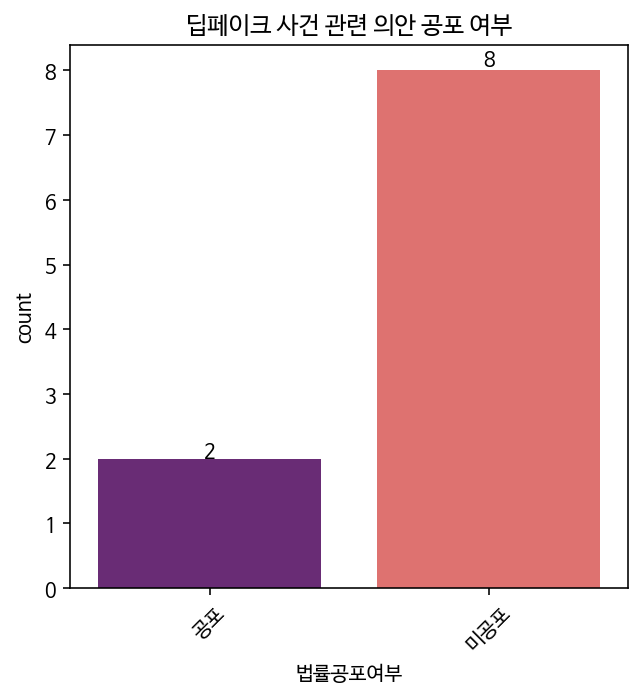

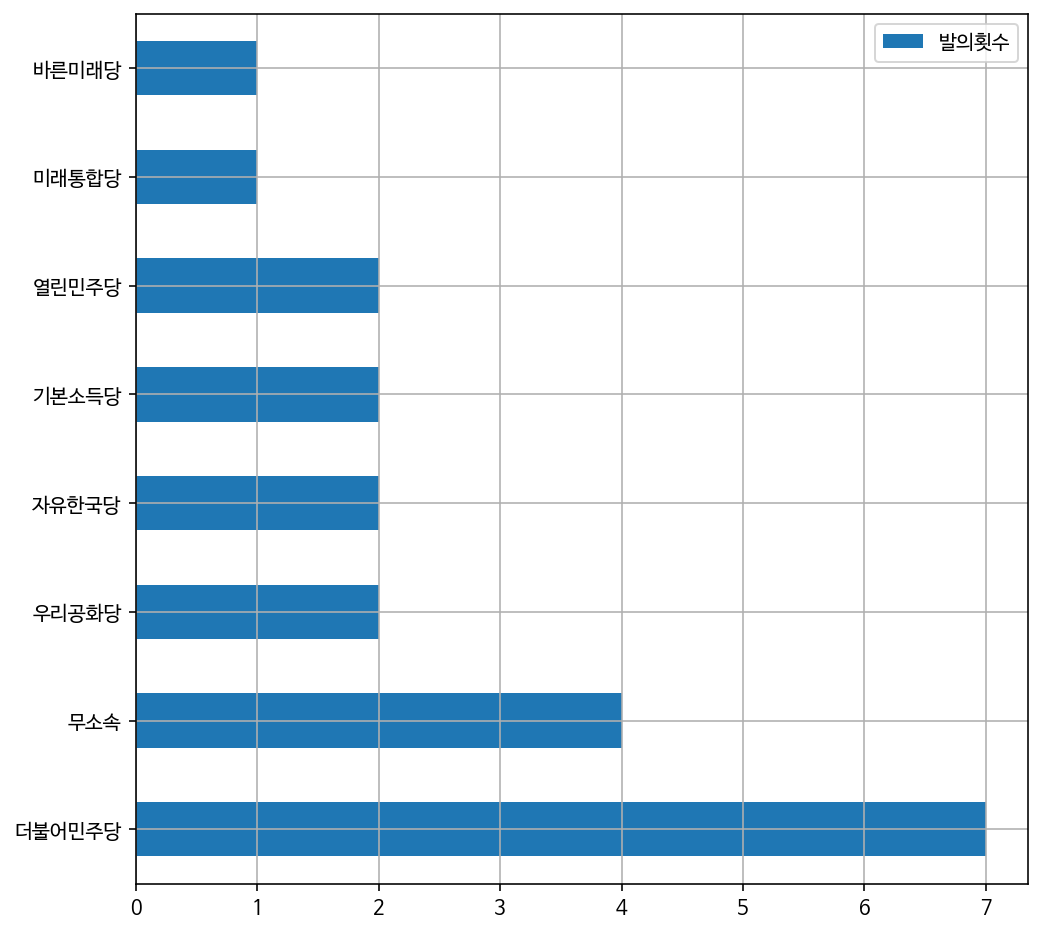

의결처리기간  의결결과
법률반영여부 의결결과                
미반영    임기만료폐기  179.00     2
반영     대안반영폐기  126.75     4
       원안가결      0.50     2

In [64]:
# 월별 법안 발의 건수
billdate_vis(deepfake, '딥페이크')

# 반영됐을 경우 평균 59일 소요 
print(deepfake['의결처리기간'].groupby(deepfake['법률반영여부']).mean(), '\n')

# 공포시까지 4일 소요됨 but 공포된 법안은 11개! 
print(deepfake['의결처리기간'].groupby(deepfake['법률공포여부']).mean())

# 사건 관련 공포 여부 합계 
proornot_vis(deepfake, '딥페이크')

# 정당별 발의의안 횟수 
party_vis(deepfake)

billresult(bill_df, deepfake)

법률공포여부
공포     1.0
미공포    6.0
Name: 더불어민주당, dtype: float64
법률공포여부
미공포    1.0
Name: 바른미래당, dtype: float64
법률공포여부
미공포    2.0
Name: 자유한국당, dtype: float64
법률공포여부
미공포    2.0
Name: 기본소득당, dtype: float64


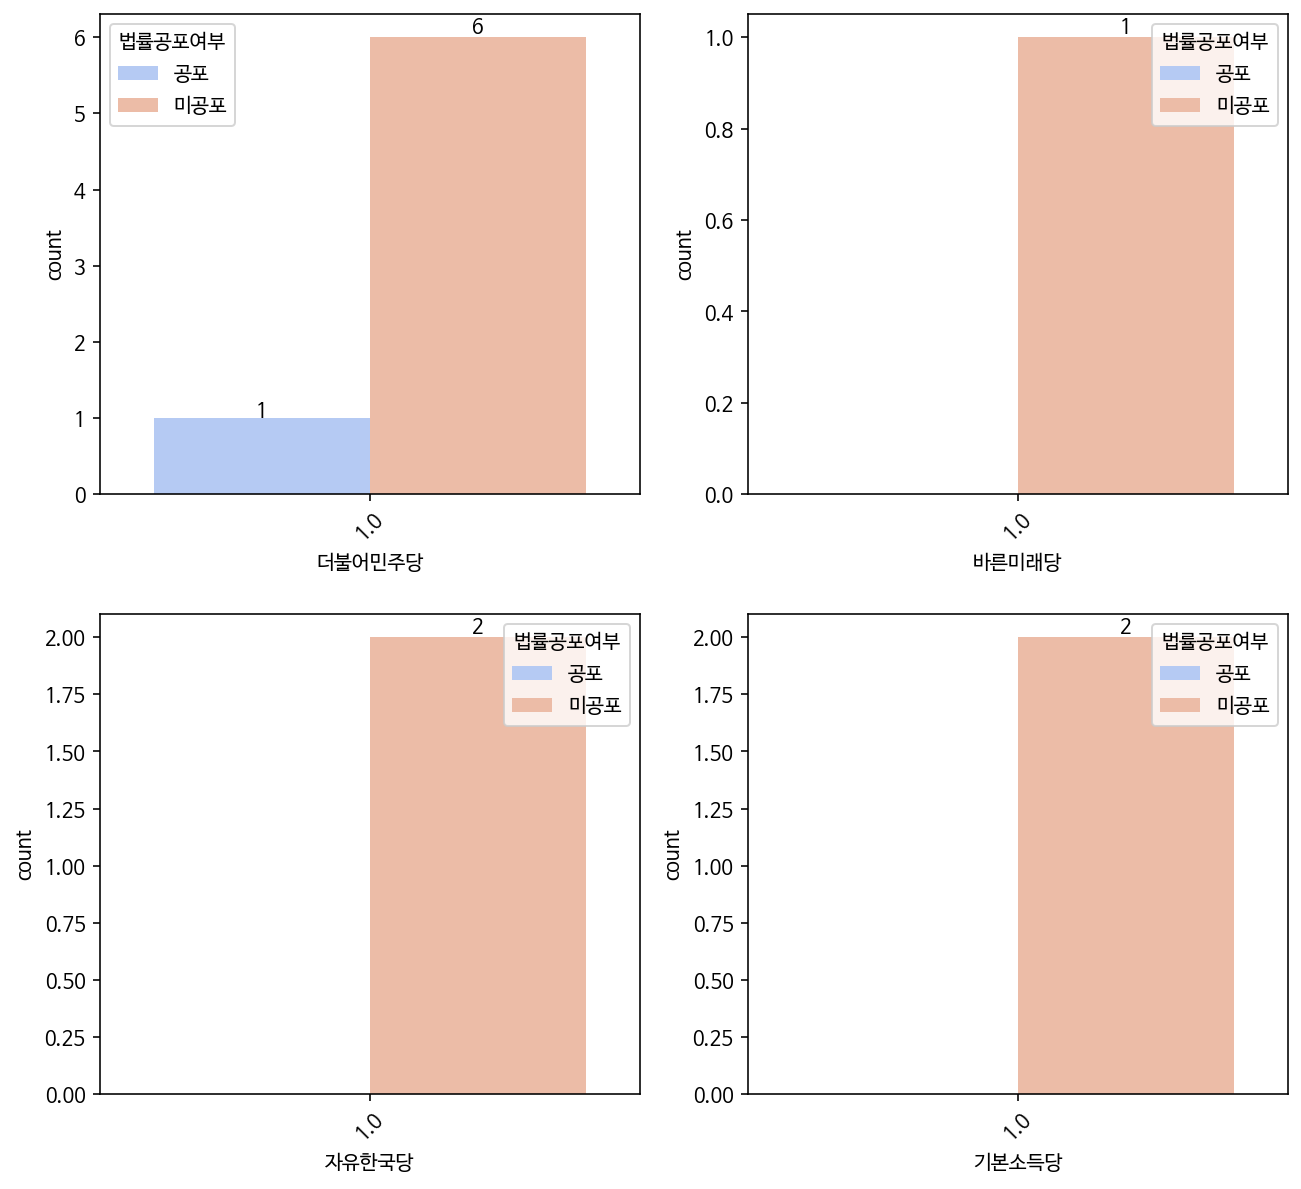

In [65]:
# 더민주, 바미당, 자한당, 정의당 
party1 = deepfake[deepfake['더불어민주당'] == 1][['더불어민주당','법률공포여부']].fillna(0)
party2 = deepfake[deepfake['바른미래당'] == 1][['바른미래당','법률공포여부']].fillna(0)
party3 = deepfake[deepfake['자유한국당'] == 1][['자유한국당','법률공포여부']].fillna(0)
party4 = deepfake[deepfake['기본소득당'] == 1][['기본소득당','법률공포여부']].fillna(0)

print(party1.groupby('법률공포여부')['더불어민주당'].sum())
print(party2.groupby('법률공포여부')['바른미래당'].sum())
print(party3.groupby('법률공포여부')['자유한국당'].sum())
print(party4.groupby('법률공포여부')['기본소득당'].sum())

partypro_vis(party1, party2, party3, party4)

### 기타

#### 김학의 성접대 관련 / 버닝썬 관련 사건
- 관련 법안은 국회의원들이 깊이 연관되어 있어서 법안이 없는건지 등 모르겠다...ㅜㅜ 
- 마약/약물 관련 법안만 특징짓기 힘들다! 모르겠다!